# **Colab for Enhancing arXiv Paper Subject Classification Using Advanced Graph Neural Networks and Enhanced Text Embeddings For Online Inference**

By Karthik Dharmarajan, Mallika Parulekar, and Arya Bakhtiar as part of the Stanford CS224W course project

This notebook demonstrates how to enhance the classification of arXiv papers into their respective computer science subject categories by using advanced graph neural networks and improved text embeddings. It walks through loading and exploring the dataset, generating richer node embeddings from paper titles and abstracts using large language models, and training GNN models (like GCN, GraphSAGE, or GAT) to improve classification accuracy. Ultimately, the notebook shows how advanced embeddings and additional features (like historical citation information) can boost performance in subject classification tasks on citation graphs.

## Device
We recommend using a GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

This Colab was originally run using **Google Colab Pro using A100 GPU**

In [1]:
import os
import time
import networkx as nx
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import itertools
from typing import Union, Tuple, Optional
import torch
import tqdm
import argparse
import seaborn as sns

from abc import ABC, abstractmethod
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install ogb
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive
!pip install xformers

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
  Preparing metadata (setup.py) ... done


We will need the following imports to run the code

In [2]:
import torch_geometric
import torch_scatter

from torch_geometric.nn import GCNConv

from torch_sparse import SparseTensor, set_diag

from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter, Linear
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset, Planetoid

from torch_geometric.data import DataLoader, Data, InMemoryDataset

import torch_geometric.nn as pyg_nn
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch_geometric.transforms import ToSparseTensor

import torch_geometric.utils as pyg_utils
from torch_geometric.utils import remove_self_loops, to_networkx, add_self_loops, softmax, degree

import torch_geometric.transforms as T

from torch_geometric.loader import NeighborLoader

import torch.optim as optim

from torch.optim import Adam, SGD, RMSprop, Adagrad

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

from tqdm import trange

from collections import deque
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import cm

## Exploratory Data Analysis

Let us go ahead and jump into the data we will be working with!

The dataset being analyzed is "ogbn-arxiv" from the Open Graph Benchmark (OGB). It represents a citation network structured as a directed graph, detailing the relationships among Computer Science (CS) papers from arXiv as cataloged by the Microsoft Academic Graph (MAG). The dataset includes:

- **Nodes**: Each node corresponds to an arXiv paper, categorized into one of 40 unique subject areas. There are 169,343 nodes in total, divided into training (90,941), validation (29,799), and testing (48,603) sets based on their publication years. Specifically, papers published up to 2017 are included in the training set, those from 2018 are in the validation set, and papers from 2019 onward are part of the test set.

- **Edges**: These represent citation links between papers. A directed edge from node A to node B indicates that paper A cites paper B. The dataset contains 1,166,243 such directed edges.

- **Node Features**: Each paper is described by a 128-dimensional feature vector. This vector is created by averaging the embeddings of the words found in the paper's title and abstract. The word embeddings are generated using the skip-gram model trained on the MAG corpus.

In this first section of the code here, we begin to load and preprocess the graph dataset using the PyTorch Geometric library.

In [3]:
# We Load the ogbn-arxiv dataset and apply SparseTensor transformation
dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/", transform=T.ToSparseTensor())

# Retrieve the first graph object from the dataset
data = dataset[0]

# We extract row and column indices from the adjacency SparseTensor
row, col, _ = data.adj_t.coo()

# Create the edge_index tensor by stacking row and col
data.edge_index = torch.stack([row, col], dim=0).long()

# Convert the adjacency matrix to a symmetric (undirected) version
data.adj_t = data.adj_t.to_symmetric()

# Select device: CUDA if available, otherwise CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the data to the selected device
data = data.to(device)

# Get the predefined train/validation/test split indices
split_idx = dataset.get_idx_split()

# Move training indices to the device
train_idx = split_idx['train'].to(device)

# display the data
display(data)

/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598], edge_index=[2, 1166243])

Here we have the `subject_areas` with their assigned categories. The dictionaries allow us to reference full category names instead of their abbreviated forms when presenting results or performing analyses.

In [4]:
# list of 40 unique subject areas for the ogbn-arxiv dataset
subject_areas = [
    "cs.NA", "cs.MM", "cs.LO", "cs.CY", "cs.CR", "cs.DC", "cs.HC", "cs.CE",
    "cs.NI", "cs.CC", "cs.AI", "cs.MA", "cs.GL", "cs.NE", "cs.SC", "cs.AR",
    "cs.CV", "cs.GR", "cs.ET", "cs.SY", "cs.CG", "cs.OH", "cs.PL", "cs.SE",
    "cs.LG", "cs.SD", "cs.SI", "cs.RO", "cs.IT", "cs.PF", "cs.CL", "cs.IR",
    "cs.MS", "cs.FL", "cs.DS", "cs.OS", "cs.GT", "cs.DB", "cs.DL", "cs.DM"
]

# Create a dictionary to map each category abbreviation to its full descriptive name
category_abbreviation_to_full = {
    "ai": "Artificial Intelligence",
    "ar": "Hardware Architecture",
    "cc": "Computational Complexity",
    "ce": "Computational Engineering, Finance, and Science",
    "cg": "Computational Geometry",
    "cl": "Computation and Language",
    "cr": "Cryptography and Security",
    "cv": "Computer Vision and Pattern Recognition",
    "cy": "Computers and Society",
    "db": "Databases",
    "dc": "Distributed, Parallel, and Cluster Computing",
    "dl": "Digital Libraries",
    "dm": "Discrete Mathematics",
    "ds": "Data Structures and Algorithms",
    "et": "Emerging Technologies",
    "fl": "Formal Languages and Automata Theory",
    "gl": "General Literature",
    "gr": "Graphics",
    "gt": "Computer Science and Game Theory",
    "hc": "Human-Computer Interaction",
    "ir": "Information Retrieval",
    "it": "Information Theory",
    "lg": "Machine Learning",
    "lo": "Logic in Computer Science",
    "ma": "Multiagent Systems",
    "mm": "Multimedia",
    "ms": "Mathematical Software",
    "na": "Numerical Analysis",
    "ne": "Neural and Evolutionary Computing",
    "ni": "Networking and Internet Architecture",
    "oh": "Other Computer Science",
    "os": "Operating Systems",
    "pf": "Performance",
    "pl": "Programming Languages",
    "ro": "Robotics",
    "sc": "Symbolic Computation",
    "sd": "Sound",
    "se": "Software Engineering",
    "si": "Social and Information Networks",
    "sy": "Systems and Control",
}

Next, we output confirmation details about the graph, including the number of nodes and edges, the shapes of the node feature matrix and edge index, and samples of node features and edge attributes if they exist. It also displays the graph labels and any additional graph attributes. Unraveling the contents of the data here will help us understand the structure and contents of the dataset before further processing or modeling.

### Dataset Summary

| **Metric**                 | **Value**                      |
|----------------------------|--------------------------------|
| Number of graphs           | 1                              |
| Number of features         | 128                            |
| Number of classes          | 40                             |
| Number of nodes            | 169,343                        |
| Number of edges            | 1,166,243                    |
| Node feature matrix shape  | `torch.Size([169343, 128])`     |
| Edge index shape           | `torch.Size([2, 1166243])`       |


In [5]:
# Printing basic information about the graph
print('Number of graphs in dataset:', len(dataset))
print('Number of Features in dataset:', dataset.num_features)
print('Number of Classes in dataset:', dataset.num_classes)
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Node feature matrix shape:", data.x.shape)
print("Edge index shape:", data.edge_index.shape)

# Explore node features; display first 5 node features
if data.x is not None:
    print("Node feature sample:", data.x[:5])

# Explore edge features; display first 5 edge attributes
if data.edge_attr is not None:
    print("Edge attribute shape:", data.edge_attr.shape)
    print("Edge attribute sample:", data.edge_attr[:5])

# Explore labels
if data.y is not None:
    print("Graph label:", data.y)

# Explore additional attributes
print("Graph data:", data)

Number of graphs in dataset: 1
Number of Features in dataset: 128
Number of Classes in dataset: 40
Number of nodes: 169343
Number of edges: 1166243
Node feature matrix shape: torch.Size([169343, 128])
Edge index shape: torch.Size([2, 1166243])
Node feature sample: tensor([[-5.7943e-02, -5.2530e-02, -7.2603e-02, -2.6555e-02,  1.3044e-01,
         -2.4139e-01, -4.4924e-01, -1.8443e-02, -8.7218e-02,  1.1232e-01,
         -9.2125e-02, -2.8956e-01, -8.1012e-02,  7.4489e-02, -1.5620e-01,
         -9.7413e-02,  1.1937e-01,  6.4575e-01,  7.7375e-02, -9.3860e-02,
         -4.0037e-01,  3.1137e-01, -5.4176e-01,  8.0455e-02, -6.9500e-03,
          5.4232e-01, -1.2230e-02, -1.8077e-01,  1.6466e-02,  5.0778e-02,
         -2.0828e-01, -8.7010e-02,  1.2363e-02,  2.8167e-01,  1.0045e-01,
         -1.6425e-01,  2.6892e-02,  7.8199e-02,  7.9534e-02, -1.3387e-02,
          2.9149e-01,  4.1601e-02, -1.4137e-01, -1.3446e-01,  1.6178e-02,
          2.8096e-01, -9.1925e-02, -2.4031e-01,  4.6179e-01,  1.8732e

In the following code below, we calculate the number of nodes in each class (subject area) within the ogbn-arxiv dataset, sort the classes by their frequency in descending order, and then map each abbreviated category to its full descriptive name. The code then visualizes the class distribution using a horizontal bar plot, displaying both the counts and percentages for each subject area. This helps in understanding the imbalance and distribution of different categories in the dataset.

From the output, we can see the top 5 most common classes in this dataset:
*   General Literature: 16.13%
*   Multiagent Systems: 13.10%
*   Multiagent Systems: 13.10%
*   Neural and Evolutionary Computing: 12.64%
*   Other Computer Science: 6.98%
*   Distributed, Parallel, and Cluster Computing: 4.65%

### Sample Graph Diagrams

Computer Vision and Pattern Recognition: 16.13%
Machine Learning: 13.10%
Information Theory: 12.64%
Computation and Language: 6.98%
Artificial Intelligence: 4.65%
Data Structures and Algorithms: 4.65%
Networking and Internet Architecture: 3.68%
Cryptography and Security: 3.46%
Distributed, Parallel, and Cluster Computing: 2.93%
Logic in Computer Science: 2.86%
Robotics: 2.84%
Social and Information Networks: 2.72%
Computer Science and Game Theory: 2.08%
Systems and Control: 1.70%
Software Engineering: 1.67%
Information Retrieval: 1.67%
Computational Complexity: 1.67%
Databases: 1.40%
Neural and Evolutionary Computing: 1.39%
Computers and Society: 1.23%
Computational Geometry: 1.23%
Discrete Mathematics: 1.20%
Programming Languages: 1.12%
Human-Computer Interaction: 0.96%
Digital Libraries: 0.89%
Formal Languages and Automata Theory: 0.75%
Sound: 0.74%
Multiagent Systems: 0.44%
Emerging Technologies: 0.44%
Multimedia: 0.41%
Symbolic Computation: 0.35%
Computational Engineering, Finance,

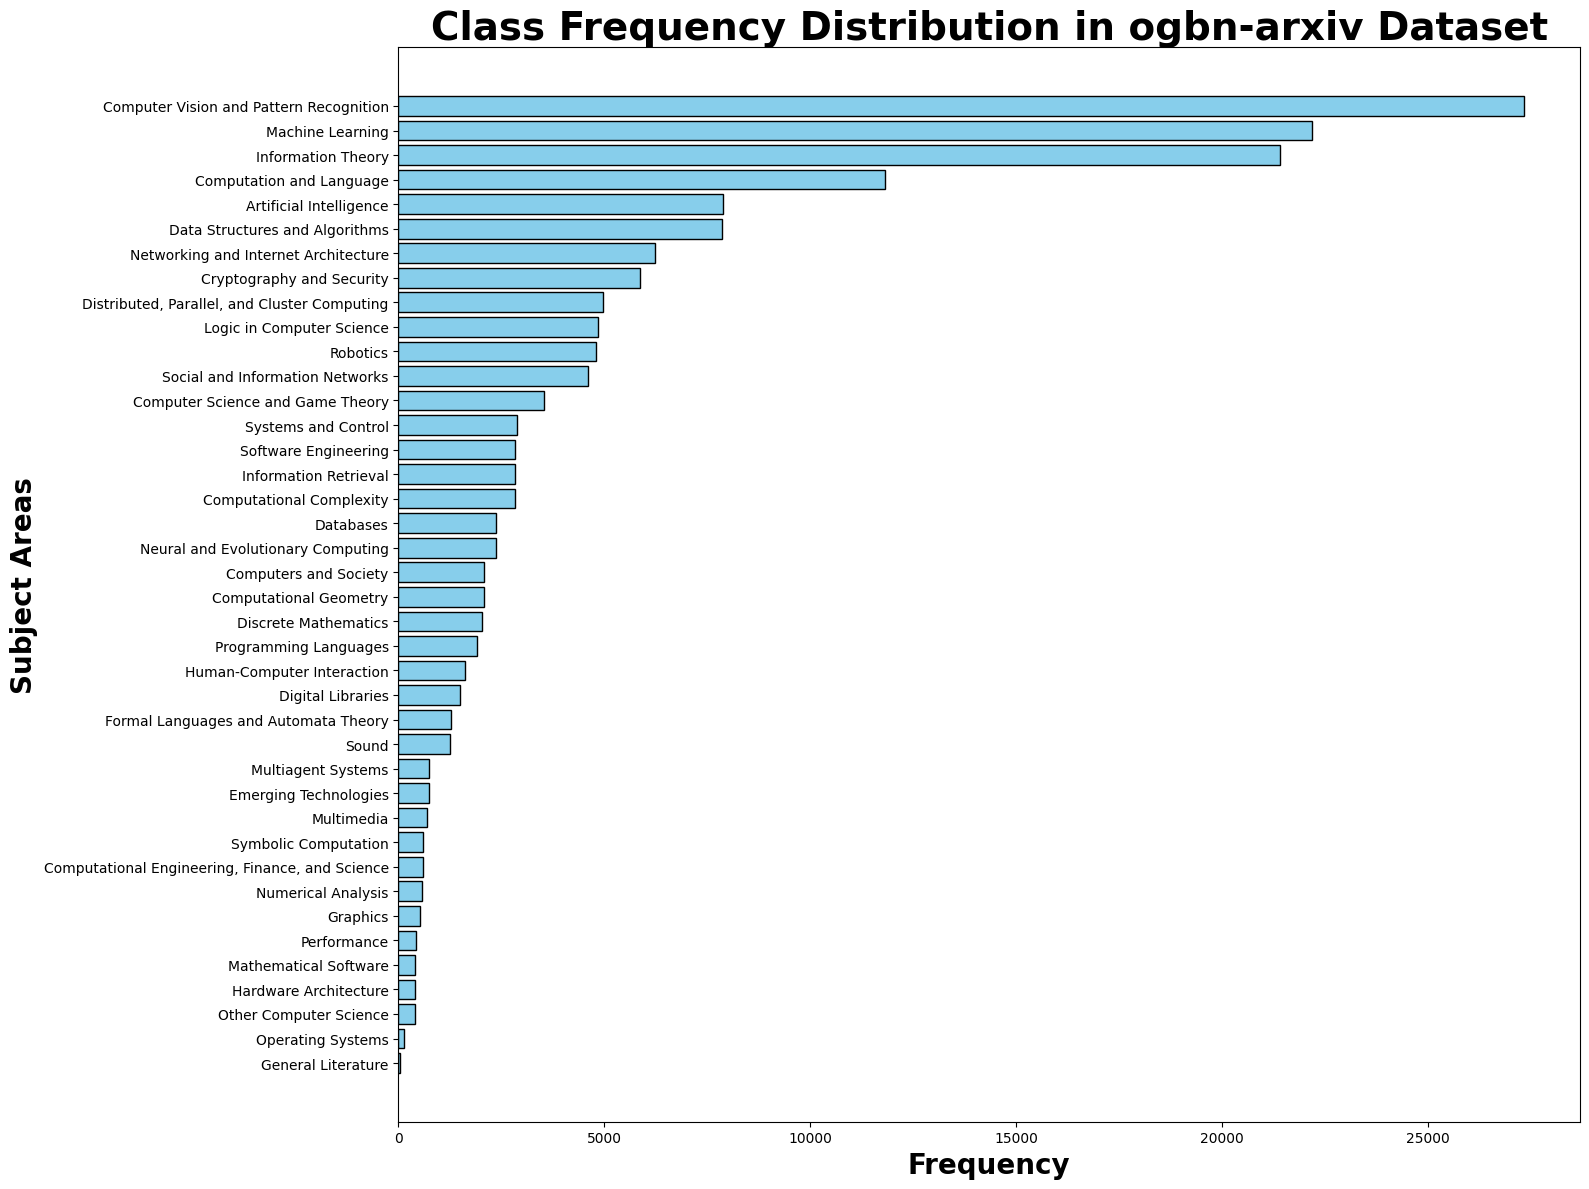

In [6]:
# Compute class counts
class_counts = np.bincount(data.y.squeeze(1).cpu().numpy())
total_nodes = class_counts.sum()

# Sort by descending frequency
sorted_indices = np.argsort(class_counts)[::-1]
sorted_counts = class_counts[sorted_indices]

# Map abbreviated categories to their full names
sorted_areas_full = []
for idx in sorted_indices:
    abbr = subject_areas[idx].split('.')[-1].lower()
    full_name = category_abbreviation_to_full.get(abbr, subject_areas[idx])
    sorted_areas_full.append(full_name)

# Creating a horizontal bar plot
plt.figure(figsize=(16, 12))
bars = plt.barh(sorted_areas_full, sorted_counts, color='skyblue', edgecolor='black')

# Invert y-axis so the largest category is at the top
plt.gca().invert_yaxis()

# Add counts and percentages for each category to the right of the bars
for bar, count, class_name in zip(bars, sorted_counts, sorted_areas_full):
    percentage = (count / total_nodes) * 100
    print(f"{class_name}: {percentage:.2f}%")

# Customize the title and axes
plt.title("Class Frequency Distribution in ogbn-arxiv Dataset", fontsize=28, fontweight='bold')
plt.xlabel("Frequency", fontsize=20, fontweight='bold')
plt.ylabel("Subject Areas", fontsize=20, fontweight='bold')

plt.tight_layout()
plt.savefig("class_distribution_horizontal.png", dpi=300)
plt.show()

Next, let us a subgraph to get a visualization of the kind of data we are working with here. It would be nice to see a sample subgraph.

Here we plot 70 nodes from the ogbn-arxiv dataset by selecting a high out-degree node from the training set and performing a breadth-first search to include its neighbors. The code then visualizes this subgrapph and we are coloring each node based on its subject area by mapping each category to a unique color, and includes labels and a legend for clarity.

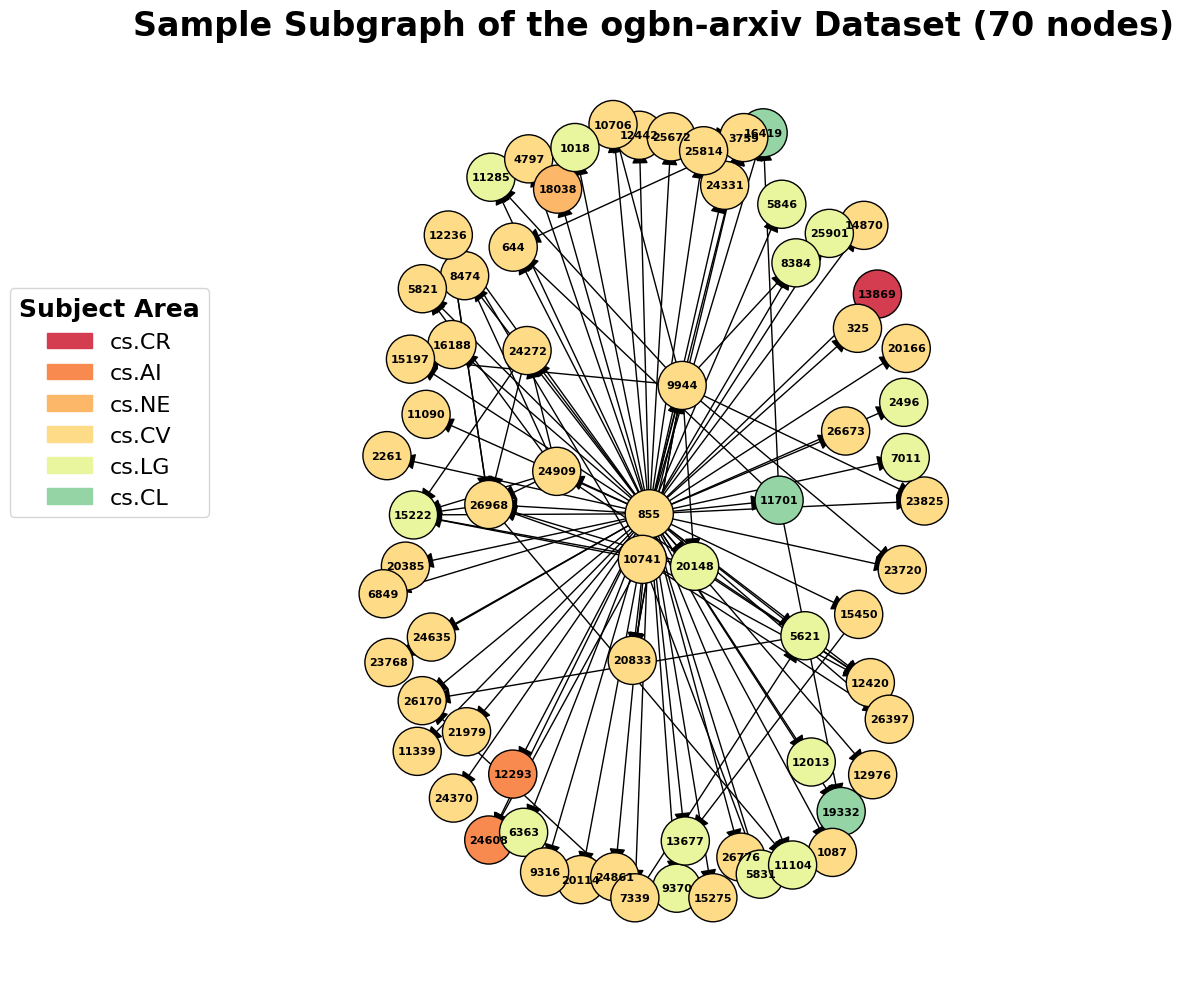

In [7]:
# We create a temporary graph by cloning node features, edge indices, and labels
temp_graph = Data(
    x=data.x.clone(),
    edge_index=data.edge_index.clone(),
    y=data.y.clone(),
)

# Here we remove self-loops from the edge index (for cleaner display of the graph)
temp_graph.edge_index, _ = remove_self_loops(temp_graph.edge_index)

# Convert the temporary graph to a directed NetworkX graph
G = to_networkx(temp_graph, to_undirected=False)

# we define the desired number of nodes for the subgraph (here for 70)
num_subgraph_nodes = 70

# Calculate out-degrees of training nodes and select a high out-degree node as the start
train_degrees = G.out_degree(train_idx.tolist())
start_node = sorted(train_degrees, key=lambda x: x[1], reverse=True)[200][0]

# Initialize visited set and queue for BFS
visited = set([start_node])
queue = deque([start_node])

# Perform BFS to extract a connected subgraph with the specified number of nodes
while queue and len(visited) < num_subgraph_nodes:
    current = queue.popleft()
    for neighbor in G.successors(current):
        if neighbor not in visited:
            visited.add(neighbor)
            queue.append(neighbor)
            if len(visited) == num_subgraph_nodes:
                break

# Create the subgraph from the visited nodes
H = G.subgraph(visited).copy()

# Flatten the labels array to a 1D numpy array
node_classes = temp_graph.y[list(visited)].view(-1).cpu().numpy()

# Define a colormap with 42 distinct colors for 40 classes
cmap = mpl.colormaps['Spectral'].resampled(42)

# Assign colors to nodes based on their class labels
node_colors = [cmap(cls) for cls in node_classes]

# This code compute positions for nodes using the spring layout algorithm
# k controls spread, scale controls layout, and iterations controls stable layout
pos = nx.spring_layout(
    H,
    seed=44,
    k=0.6,
    scale=1.0,
    iterations=30
)

# Initialize the plot with specified figure size
plt.figure(figsize=(11, 10))

# Draw nodes with assigned colors and black edges
nx.draw_networkx_nodes(
    H, pos,
    node_color=node_colors,
    node_size=1200,
    edgecolors='black'
)

# Draw node labels with specified font size and style
nx.draw_networkx_labels(H, pos, font_size=8, font_color='black', font_weight="bold")  # Adjust font_size for labels

# Draw directed edges with black color and arrow properties
nx.draw_networkx_edges(H, pos, edge_color='black', arrows=True, arrowstyle='-|>', arrowsize=25)

# Identify unique classes present in the subgraph
classes_in_subgraph = sorted(set(node_classes))
legend_handles = []

# Create legend patches for each class
for cls in classes_in_subgraph:
    area_name = subject_areas[cls]  # Map the class index to a subject area name
    patch = mpatches.Patch(color=cmap(cls), label=f"{area_name}")
    legend_handles.append(patch)

# Add the legend to the plot with specified properties
legend = plt.legend(
    handles=legend_handles, title='Subject Area', title_fontsize=18, fontsize=16,
    loc='upper left', bbox_to_anchor=(-0.5, 0.75), frameon=True
)
plt.setp(legend.get_title(), fontweight='bold')

# Set the plot title with specified font properties
plt.title("Sample Subgraph of the ogbn-arxiv Dataset (70 nodes)", fontweight='bold', fontsize=24)

# Remove axis for a cleaner visualization
plt.axis('off')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("sample_arvix_subgraph.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Wow! The subgraph looks pretty cool. Let us see if we can get a bigger view of the dataset.

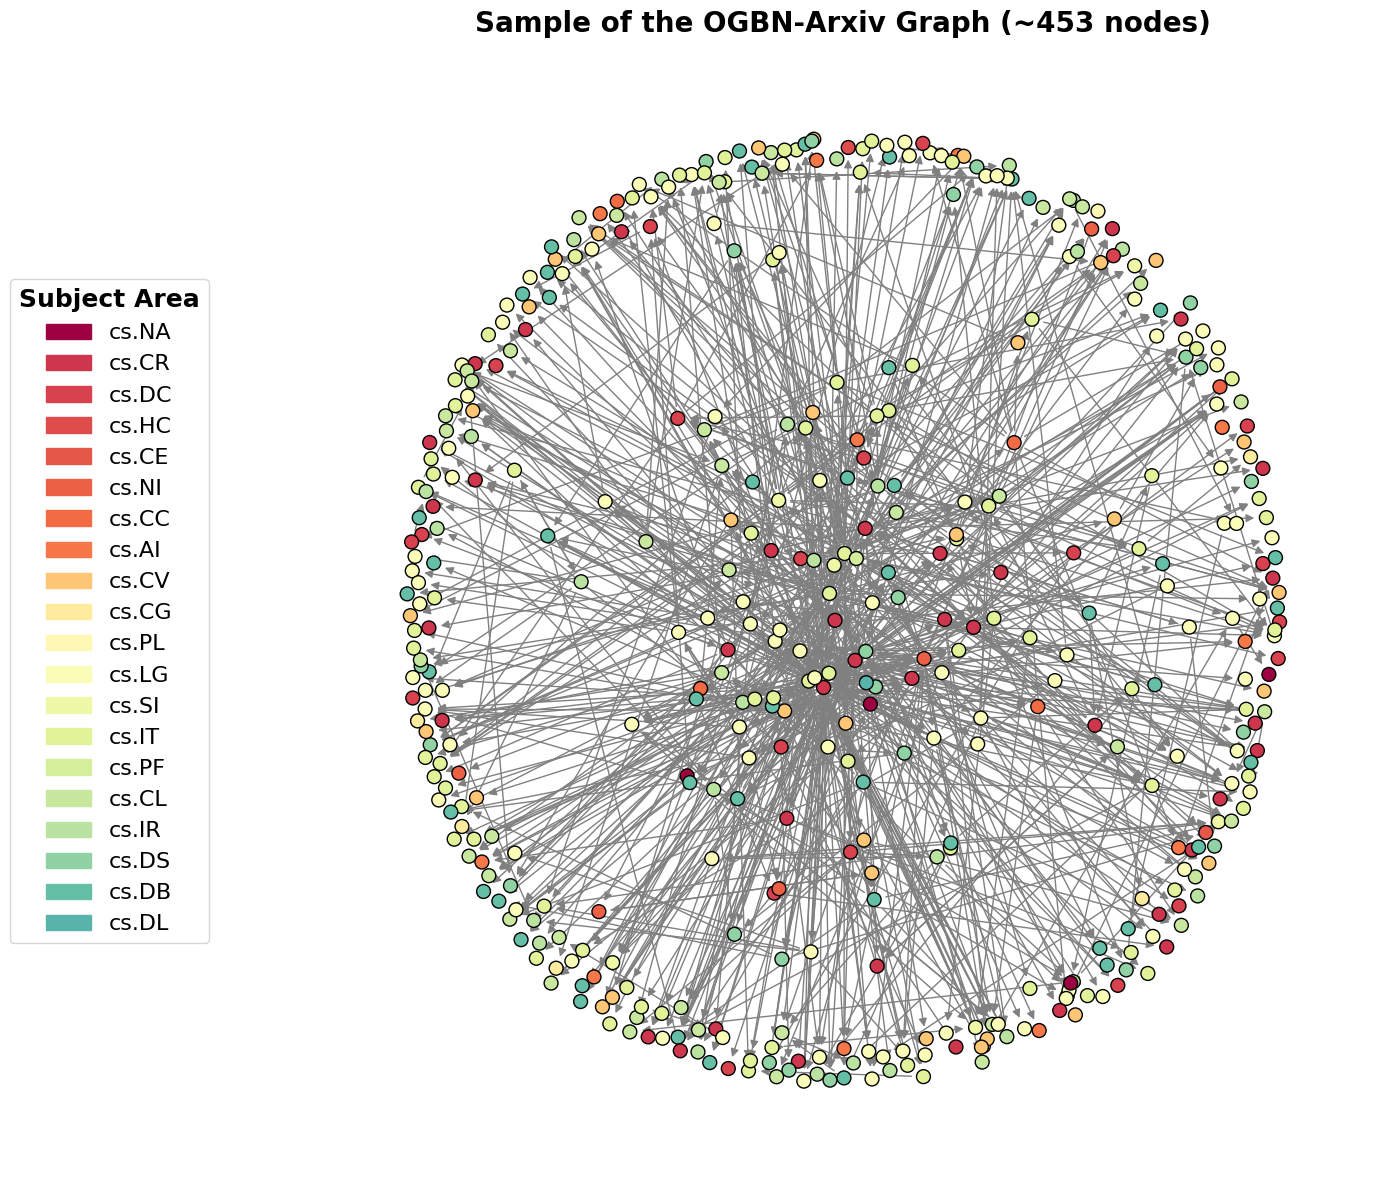

In [8]:
# Number of nodes to include in each BFS expansion
num_subgraph_nodes = 100

# Total number of BFS expansions from different seed nodes
num_subgraphs = 10

# Clone the data to create a temporary graph and remove self-loops
temp_graph = data.clone()
temp_graph.edge_index, _ = pyg_utils.remove_self_loops(temp_graph.edge_index)

# Convert the temporary graph to a directed NetworkX graph
G_full = pyg_utils.to_networkx(temp_graph, to_undirected=False)

# Retrieve training node indices and determine spacing for seed selection
train_nodes = split_idx['train'].cpu().numpy()
spacing = len(train_nodes) // num_subgraphs
seed_nodes = [train_nodes[i * spacing] for i in range(num_subgraphs)]  # Select evenly spaced seed nodes

# Initialize a set to store all nodes included in the subgraphs
all_subgraph_nodes = set()

# Iterate over each seed node to perform BFS and collect subgraph nodes
for seed in seed_nodes:
    visited = set([seed])
    queue = deque([seed])
    while queue and len(visited) < num_subgraph_nodes:
        current = queue.popleft()
        for neighbor in G_full.successors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) == num_subgraph_nodes:
                    break
    all_subgraph_nodes.update(visited)

# Extract the induced subgraph of these combined nodes
H_global = G_full.subgraph(all_subgraph_nodes).copy()

# Color nodes by their class
node_classes = temp_graph.y[list(all_subgraph_nodes)].view(-1).cpu().numpy()
cmap = mpl.colormaps['Spectral'].resampled(47)
node_colors = [cmap(cls) for cls in node_classes]

# Compute positions using a spring layout
pos = nx.spring_layout(H_global, seed=44, k=0.8, scale=3.0, iterations=100)

plt.figure(figsize=(14, 12))

# Draw the nodes with assigned colors and black edges
nx.draw_networkx_nodes(H_global, pos,
                       node_color=node_colors,
                       node_size=100,
                       edgecolors='black')

# Draw the edges with gray color and arrow properties to indicate direction
nx.draw_networkx_edges(H_global, pos, edge_color='gray', arrows=True, arrowstyle='-|>', arrowsize=12)

# Identify unique classes present in the subgraph for the legend
classes_in_subgraph = sorted(set(node_classes))
legend_handles = []

# Create legend patches for each unique class in the subgraph
for cls in classes_in_subgraph:
    area_name = subject_areas[cls]  # Map class index to subject area name
    patch = mpatches.Patch(color=cmap(cls), label=f"{area_name}")
    legend_handles.append(patch)

# Add the legend to the plot with specified formatting and positioning
legend = plt.legend(
    handles=legend_handles, title='Subject Area', title_fontsize=18, fontsize=16,
    loc='upper left', bbox_to_anchor=(-0.3, 0.8), frameon=True
)
plt.setp(legend.get_title(), fontweight='bold')  # Bold the legend title

plt.title(f"Sample of the OGBN-Arxiv Graph (~{len(all_subgraph_nodes)} nodes)", fontsize=20, fontweight='bold')

# Adjust layout and save the figure with high resolution
plt.axis('off')
plt.tight_layout()
plt.savefig("large_arxiv_subgraph.png", dpi=300, bbox_inches='tight')
plt.show()

## Graph Neural Network (GNN) Models

We are finally going to dive into the Graph Neural Network (GNN) Models!

In the following sections, we begin to showcase the implementations of several GNN models we will use for experiments. As we explore these examples, you’ll notice a set of common traits and design principles that are frequently seen in GNN architectures:

- **Message Passing and Aggregation:**  
  Nearly all GNNs rely on iterative message passing, where each node gathers information from its neighbors at each layer. This aggregation process enables nodes to build more expressive representations based on their local neighborhoods.

- **Trainable Parameters:**  
  GNN layers often include learnable weight matrices. These parameters transform raw inputs or intermediate node embeddings into more meaningful representations, and they are adjusted during training to minimize a chosen loss function.

- **Nonlinear Activations:**  
  Nonlinear functions—such as ReLU or LeakyReLU—are commonly integrated into GNN layers. They help the model capture complex patterns that linear transformations alone cannot represent.

- **Attention and Gating:**  
  Some GNN variants incorporate attention mechanisms or gating strategies to selectively focus on more important neighbors. This flexibility allows the model to handle diverse graph structures more effectively.

- **Normalization:**  
  To maintain stable training and avoid exploding or vanishing gradients, GNN models often employ normalization strategies. These can include degree normalization, layer normalization, or other techniques to improve model performance.

As you we through the code snippets and explanations, we will see how these concepts come together to form different GNN models.

### Graph Convolutional Network (GCN)

The Graph Convolutional Network (GCN) is one of the fundamental GNN architectures that operates directly on graphs. It updates node embeddings by aggregating features from each node’s local neighborhood. Formally, if $\mathbf{H}^{(k)} \in \mathbb{R}^{N \times d_k }$ represents node embeddings at the $k$-th layer and $\hat{\mathbf{A}}$ is the normalized adjacency matrix (including self-loops), the GCN layer update rule is:

\begin{equation} \mathbf{H}^{(k+1)} = \sigma\left( \hat{\mathbf{D}}^{-\frac{1}{2}} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-\frac{1}{2}} \mathbf{H}^{(k)} \mathbf{W}^{(k)} \right)
\end{equation}

where:

- $\mathbf{H}^{(k)}$ is the matrix of node representations at layer $k$.
- $\hat{\mathbf{A}} = \mathbf{A} + \mathbf{I}$ is the adjacency matrix with self-loops added.
- $\hat{\mathbf{D}}$ is the diagonal degree matrix of $\hat{\mathbf{A}}$.
- $\mathbf{W}^{(k)}$ is the learnable weight matrix at layer $k$.
- $\sigma(\cdot)$ is an activation function, such as ReLU.

In the following code section, the `GCN` class in our notebook defines a multi-layer GCN. It sets up several GCN layers, applies dropout and batch normalization where appropriate, and produces final node embeddings suitable for classification. By calling `model(data.x, data.adj_t)`, we perform forward propagation through the GCN layers, computing updated node embeddings that incorporate structural and feature information from the graph.

In [ ]:
class GCN(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) for node classification tasks.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, concat_prev_year=False, prev_year_feats=None, return_embeds=False):
        """
        Initializes the GCN model.

        Args:
            - input_dim (int): Dimension of input features.
            - hidden_dim (int): Dimension of hidden layers.
            - output_dim (int): Dimension of output layer.
            - num_layers (int): Number of GCN layers.
            - dropout (float): Dropout rate.
            - concat_prev_year (bool, optional): Whether to concatenate previous year's features. Defaults to False.
            - prev_year_feats (torch.Tensor, optional): Previous year's features to concatenate. Defaults to None.
            - return_embeds (bool, optional): Whether to return embeddings instead of final output. Defaults to False.
        """
        super(GCN, self).__init__()

        # Store concatenation flags and features
        self.concat_prev_year = concat_prev_year
        self.prev_year_feats = prev_year_feats

        # Initialize lists for convolutional and batch normalization layers
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        # First GCN layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        # Additional GCN layers
        for i in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        # Final GCN layer
        self.convs.append(GCNConv(hidden_dim, output_dim))

        # Softmax layer for output
        self.softmax = torch.nn.LogSoftmax(dim=1)

        # Dropout rate
        self.dropout = dropout

        # Flag to return embeddings
        self.return_embeds = return_embeds

        # If concatenating previous year's features, define post-processing layers
        if self.concat_prev_year:
            post_mp_in_dim = output_dim + 40
            self.post_mp = nn.Sequential(
                nn.Linear(post_mp_in_dim, hidden_dim),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, output_dim)
            )

    def reset_parameters(self):
        """
        Resets parameters of all layers in the model.
        """
        # Reset parameters of convolutional layers
        for conv in self.convs:
            conv.reset_parameters()

        # Reset parameters of batch normalization layers
        for bn in self.bns:
            bn.reset_parameters()

        # If using post-processing layers, reset their parameters as well
        if self.concat_prev_year:
            for layer in self.post_mp:
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

    def forward(self, x, adj_t):
        """
        Forward pass of the GCN.

        Args:
            - x (torch.Tensor): Input node features.
            - adj_t (torch.Tensor): Adjacency matrix in sparse format.

        Returns:
            - torch.Tensor: Log probabilities for each class or embeddings if specified.
        """

        # Initialize output with input features
        out = x

        # Apply GCN layers except the last one
        for i in range(len(self.convs) - 1):

            # Graph convolution
            out = self.convs[i](out, adj_t)

            # Batch normalization
            out = self.bns[i](out)

            # ReLU activation
            out = F.relu(out)

            # Dropout
            out = F.dropout(out, p=self.dropout, training=self.training)

        # Apply the final GCN layer
        out = self.convs[-1](out, adj_t)

        # If not returning embeddings, apply additional processing
        if not self.return_embeds:
            if self.concat_prev_year:

                # Concatenate with previous year's features
                out = torch.cat([out, self.prev_year_feats], dim=1)

                # Post-processing with linear layers
                out = self.post_mp(out)

            # Apply log-softmax for output
            out = self.softmax(out)

        return out

### GNNStack

While GCN focuses on a specific type of GNN layer, we often want a more flexible approach. Our `GNNStack` is a helper class that enables easy experimentation with different GNN architectures. It can stack multiple layers of various GNN types (e.g., GraphSAGE or GAT) and then feed their output into a multi-layer perceptron (MLP) for classification.

In the following code section, the `GNNStack` class in our code allows us to:
1. Choose the GNN model type (e.g., GraphSAGE or GAT) by passing the appropriate arguments.
2. Build a sequence (stack) of GNN layers to process node features.
3. Optionally concatenate additional features (like previous-year information) before classification.
4. Apply a final MLP to generate class probabilities.


In [ ]:
class GNNStack(torch.nn.Module):
    """
    A stack of Graph Neural Network (GNN) layers followed by a post-processing
    multi-layer perceptron (MLP). This class supports configurable model types
    (GraphSAGE or GAT), multiple layers, and optional concatenation of additional
    node features from previous-year data.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False, concat_prev_year=False, prev_year_feats=None):
        super(GNNStack, self).__init__()
        """
        Args:
            - input_dim (int): Dimensionality of input features per node.
            - hidden_dim (int): Dimensionality of the hidden layer(s).
            - output_dim (int): Dimensionality of the output features.
            - args (namespace): Arguments containing model configuration, including:
                - model_type (str): Type of GNN layer to use ('GraphSage' or 'GAT').
                - num_layers (int): Number of GNN layers to stack.
                - heads (int): Number of attention heads for GAT (if applicable).
                - dropout (float): Dropout rate.
            - emb (bool, optional): If True, returns node embeddings before softmax.
                Defaults to False.
            - concat_prev_year (bool, optional): If True, concatenates previous-year
                features (size 40) to the node embeddings before the final MLP.
                Defaults to False.
        """
        self.concat_prev_year = concat_prev_year
        self.prev_year_feats = prev_year_feats

        # Build the specified GNN convolution model (GraphSAGE or GAT)
        conv_model = self.build_conv_model(args.model_type)

        # Create the GNN layers
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # Determine input dimension for post-processing MLP
        # If concatenating previous-year features, add 40 to the dimension
        post_mp_in_dim = args.heads * hidden_dim + (40 if self.concat_prev_year else 0)

        # Post-message-passing MLP to generate the final output
        self.post_mp = nn.Sequential(
            nn.Linear(post_mp_in_dim, hidden_dim),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim)
        )

        self.dropout = args.dropout
        self.num_layers = args.num_layers
        self.emb = emb

    def build_conv_model(self, model_type):
        """
        Returns the appropriate GNN layer class based on the specified model type.

        Args:
            - model_type (str): The model type, either 'GraphSage' or 'GAT'.

        Returns:
            - class: The GNN layer class to be used.
        """
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        """
        Defines the forward pass of the GNN stack.

        Args:
            - data (Data): A PyG Data object containing:
                - x (Tensor): Node feature matrix of shape [num_nodes, input_dim].
                - edge_index (LongTensor): Graph connectivity in COO format.
                - batch (LongTensor): Batch vector.
                  if concat_prev_year is True.

        Returns:
            Tensor:
                - If emb is True, returns node embeddings of shape [num_nodes, output_dim].
                - Otherwise, returns the log_softmax output of shape [num_nodes, output_dim].
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Pass through each GNN layer
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Concatenate previous-year features if requested
        if self.concat_prev_year:
            x = torch.cat([x, self.prev_year_feats], dim=1)

        # Pass through the post-processing MLP
        x = self.post_mp(x)

        # If embeddings are requested, return them before softmax
        if self.emb == True:
            return x

        # Otherwise, return log-softmax predictions
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        """
        Computes the loss given predictions and labels.

        Args:
            - pred (Tensor): Predictions from the model (log-probabilities).
            - label (Tensor): Ground-truth labels.

        Returns:
            - Tensor: Loss value computed using negative log-likelihood loss.
        """
        return F.nll_loss(pred, label)

### GraphSage

GraphSAGE is a GNN architecture designed for inductive learning. It generates node embeddings by aggregating features from a node and its local neighborhood using summation, allowing for inductive learning on large graphs. Unlike GCN, which uses the full neighborhood, GraphSAGE allows for scalable training by sampling a fixed-size set of neighbors. Instead of relying on full graph connectivity (which can be expensive), GraphSAGE samples a fixed number of neighbors for each node and aggregates their features. This approach generalizes better to unseen nodes and larger graphs.

A common variant of the GraphSAGE update rule is:

\begin{equation} \mathbf{h}_u^{(k+1)} = \sigma\left( \mathbf{W}^{(k)} \left( \mathbf{h}_u^{(k)} + \sum_{v \in N(u)} \mathbf{h}_v^{(k)} \right) \right) \end{equation}

where:
- $\mathbf{h}_v^{(k)}$ is the embedding of node $v$ at layer $k$.
- $N(u)$ are neighbors of $v$.
- $\mathbf{W}^{(k)}$ are trainable weight matrices.
- $\sigma(\cdot)$ is a nonlinear activation.

In the following section of our notebook, the `GraphSage` class implements the message passing and aggregation steps for GraphSAGE layers. It takes node features, collects their neighbors' features, averages them, and transforms them through linear layers and non-linearities. By integrating `GraphSage` layers into `GNNStack`, we can build multi-layer GraphSAGE-based models and easily train them for node classification tasks.

In [ ]:
class GraphSage(MessagePassing):
    """
    The GraphSAGE layer implementation based on the "Inductive Representation
    Learning on Large Graphs" paper by Hamilton et al. This layer aggregates
    the features of neighbor nodes, applies a linear transformation, and then
    optionally normalizes the output.
    """

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        """
        Args
          - in_channels (int) Size of each input node feature
          - out_channels (int) Size of each output node feature
          - normalize (bool, optional) If True, output node embeddings are normalized. Defaults to True
          - bias (bool, optional) If True, adds a learnable bias to the linear layers. Defaults to False
          - **kwargs Additional keyword arguments for MessagePassing
        """
        super(GraphSage, self).__init__(**kwargs)

        # Store input parameters for later reference
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        # Define the linear transformations for the original node features and the aggregated neighbor features
        self.lin_l = nn.Linear(in_features=self.in_channels, out_features=self.out_channels, bias=bias)
        self.lin_r = nn.Linear(in_features=self.in_channels, out_features=self.out_channels, bias=bias)

        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        """
        Resets parameters in the linear layers to their initial state.
        """
        # Reset the parameters of both linear layers to their default initialization
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """
        Forward pass of the GraphSAGE layer.

        Args
         - x (Tensor) Node feature matrix of shape [num_nodes, in_channels]
         - edge_index (LongTensor) Graph connectivity in COO format with shape [2, num_edges]
         - size (tuple, optional) The size of the bipartite graph. If not given, it is computed from edge_index

        Returns
         - Tensor The updated node features of shape [num_nodes, out_channels]
        """

        # Perform message passing to aggregate features from neighbors
        message_passing_output = self.propagate(edge_index, x=(x, x), size=size)

        # Combine the original node features (lin_l(x)) with the aggregated neighbor features (lin_r(message_passing_output))
        out = self.lin_l(x) + self.lin_r(message_passing_output)

        # Normalize the output node features if required
        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

    def message(self, x_j):
        """
        Constructs messages to be passed to target nodes.

        Args
         - x_j (Tensor) Features of source nodes

        Returns
         - Tensor Messages for each edge
        """
        # Here, the messages are simply the features of the source nodes
        out = x_j
        return out

    def aggregate(self, inputs, index, dim_size = None):
        """
        Aggregates messages from neighboring nodes.

        Args
         - inputs (Tensor) Messages from source nodes
         - index (LongTensor) Indices of target nodes for each message
         - dim_size (int, optional) The size of the output along the node dimension

        Returns
         - Tensor Aggregated node features
        """
        # Use mean aggregation to combine neighbor messages
        out = torch_scatter.scatter(src=inputs, index=index, dim=self.node_dim, dim_size=dim_size, reduce='mean')
        return out

### Graph Attention Network (GAT)

The Graph Attention Network (GAT) introduces an attention mechanism to assign different weights to nodes in a neighborhood, allowing the model to focus on the most relevant neighbors. Unlike GCN or GraphSAGE, which treat each neighbor’s contribution equally (or sample neighbors), GAT learns attention coefficients that indicate how important each neighbor is to a given node.

\begin{equation} \mathbf{h}_u^{(k+1)} = \sigma\left( \sum_{v \in N(u)} \alpha_{uv}^{(k)} \mathbf{W}^{(k)} \mathbf{h}_v^{(k)} \right) \end{equation}

where $\sigma(\cdot)$ is the activation function, $\mathbf{W}^{(k)}$ is the learnable weight matrix at layer $k$, and $\alpha_{uv}^{(k)}$ are the attention coefficients computed as:

\begin{equation} e_{uv}^{(k)} = \text{LeakyReLU}\left( \mathbf{a}^{(k)^\top} \left[ \mathbf{W}^{(k)} \mathbf{h}_u^{(k)} \Vert \mathbf{W}^{(k)} \mathbf{h}_v^{(k)} \right] \right) \end{equation}

\begin{equation} \alpha_{uv}^{(k)} = \frac{ \exp\left( e_{uv}^{(k)} \right) }{ \sum\limits_{t \in N(u)} \exp\left( e_{ut}^{(k)} \right) }. \end{equation}

In these equations:

- $\mathbf{h}_u^{(k)}$ is the representation of node $u$ at layer $k$.
- $N(u)$ represents a sampling of the set of neighboring nodes of node $u$.
- $\mathbf{W}^{(k)}$ is the learnable weight matrix at layer $k$.
- $\mathbf{a}^{(k)}$ is the learnable attention vector at layer $k$.
- $\Vert$ denotes vector concatenation.
- $\text{LeakyReLU}(\cdot)$ is the activation function with a negative slope.

In the following section of our notebook, the `GAT` class in the notebook defines how to compute attention coefficients and aggregate node features based on these learned attention weights. By using this class, we can build models that focus on the most relevant edges, potentially improving performance on complex graphs. Integrating `GAT` layers into `GNNStack` allows for flexible experimentation with attention-based GNNs, adjusting the number of heads, layers, or hidden dimensions as needed.

In [ ]:
class GAT(MessagePassing):
    """
    The Graph Attention Network (GAT) layer implementation based on the "Graph
    Attention Networks" paper by Veličković et al. It computes attention weights
    for neighbor nodes and aggregates their features accordingly.
    """

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        """
        Args
          - in_channels (int) Size of each input node feature
          - out_channels (int) Size of each output node feature per attention head
          - heads (int, optional) Number of attention heads. Defaults to 2
          - negative_slope (float, optional) Negative slope for the LeakyReLU used in computing attention weights. Defaults to 0.2
          - dropout (float, optional) Dropout rate for attention coefficients. Defaults to 0
          - **kwargs Additional keyword arguments for MessagePassing
        """

        super(GAT, self).__init__(node_dim=0, **kwargs)

        # Store model hyperparameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        # Linear transformations for node features (for both source and target since GAT uses shared weights)
        self.lin_l = nn.Linear(in_features=in_channels, out_features=heads*out_channels, bias=False)
        self.lin_r = self.lin_l

        # Learnable attention vectors for each head
        self.att_l = nn.Parameter(torch.Tensor(heads, out_channels))
        self.att_r = nn.Parameter(torch.Tensor(heads, out_channels))

        # Initialize all parameters
        self.reset_parameters()

    def reset_parameters(self):
        """
        Resets parameters in the linear layers and attention parameters.
        """
        # Xavier initialization for weight matrices and attention parameters
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        """
        Forward pass of the GAT layer.

        Args
         - x (Tensor) Node feature matrix of shape [num_nodes, in_channels]
         - edge_index (LongTensor) Graph connectivity in COO format with shape [2, num_edges]
         - size (tuple, optional) The size of the bipartite graph. If not given, it is computed from edge_index

        Returns
         - Tensor The updated node features of shape [num_nodes, heads*out_channels]
        """

        # Number of attention heads and output dimension per head
        H, C = self.heads, self.out_channels

        # Transform node features for source (x_l) and target (x_r)
        x_l = self.lin_l(x).view(-1, H, C)
        x_r = self.lin_r(x).view(-1, H, C)

        # Compute attention coefficients for source and target features
        alpha_l = (x_l*self.att_l.unsqueeze(0)).sum(dim=-1)
        alpha_r = (x_r*self.att_r.unsqueeze(0)).sum(dim=-1)

        # Propagate messages through the graph and apply attention
        output = self.propagate(edge_index=edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)

        # Reshape the output to have [num_nodes, heads*out_channels]
        out = output.view(-1, H * C)

        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        """
        Constructs messages and computes attention for edges.

        Args
         - x_j (Tensor) Transformed source node features
         - alpha_j (Tensor) Attention coefficients for source nodes
         - alpha_i (Tensor) Attention coefficients for target nodes
         - index (LongTensor) Indices of target nodes for each message
         - ptr (LongTensor, optional) If given, used for segmenting edges for variable-sized graphs
         - size_i (int) Number of target nodes

        Returns
         - Tensor Messages weighted by attention coefficients
        """

        # Compute the edge-level attention scores using a LeakyReLU on (alpha_i + alpha_j)
        final_attention_weights_e = F.leaky_relu(input=alpha_i+alpha_j, negative_slope=self.negative_slope)

        # Normalize the attention scores across all edges for each target node
        alpha = softmax(src=final_attention_weights_e, index=index, ptr=ptr, num_nodes=size_i)

        # Apply dropout to attention coefficients for regularization
        alpha = F.dropout(input=alpha, p=self.dropout, training=self.training)

        # Weight the source node features by the normalized attention coefficients
        out = x_j * alpha.view(-1, self.heads, 1)

        return out

    def aggregate(self, inputs, index, dim_size = None):
        """
        Aggregates messages from neighboring nodes using sum reduction.

        Args
         - inputs (Tensor) Messages from source nodes
         - index (LongTensor) Indices of target nodes for each message
         - dim_size (int, optional) Size of the output along the node dimension

        Returns
         - Tensor Aggregated node features after summation over neighbors
        """
        # Sum the messages from all neighbors to get the final aggregated representation
        out = torch_scatter.scatter(src=inputs, index=index, dim=0, dim_size=dim_size, reduce='sum')
        return out

## Node Embedding Methods

In this follow next section, we focus on enhancing the node feature representations for the **ogbn-arxiv** dataset by leveraging advanced text-embedding models. The ultimate aim is to improve the classification accuracy of research papers into their correct subject areas by using richer semantic embeddings of their titles and abstracts.

As we discussed earlier, the **ogbn-arxiv** dataset provides a large citation network of research papers, each annotated with a subject category (e.g., Machine Learning, Computer Vision). Initially, each paper’s node feature is a simple, static 128-dimensional vector derived from skip-gram word embeddings. While convenient, these basic embeddings may fail to fully capture the nuanced, evolving language of cutting-edge research topics. As a result, classifying newly emerging or evolving research fields can be challenging.

**Overview of the Models**

1. **DeBERTa (Decoding-enhanced BERT with Disentangled Attention)**: [DeBERTa](https://arxiv.org/abs/2006.03654) is a transformer-based language model that improves upon BERT and RoBERTa architectures. It uses disentangled attention mechanisms, which help the model understand both the positional and content aspects of words more effectively. This leads to richer sentence-level embeddings that can better represent subtle differences in research topics.

2. **Stella (dunzhang/stella_en_400M_v5)**: [Stella](https://huggingface.co/dunzhang/stella_en_400M_v5) is a sentence-transformer model designed for high-quality sentence embeddings. By encoding each paper’s title and abstract, we obtain embeddings that capture global semantics beyond simple word averaging. This is particularly helpful when dealing with complex, technical language found in scientific documents.

Now we begin to dive in and discuss the next section of code that is presented that involves us using this model for our investigation. We will first discuss an overview of the code in the section.

- **`RawTextExtractor` Class:** This class reads a `titleabs.tsv` file along with a `nodeidx2paperid.csv.gz` mapping file. It provides a method `get_title_and_abstract(node_indices)` to seamlessly fetch the textual data (titles and abstracts) for any given set of node indices from the ogbn-arxiv dataset.

- **`DebertaEmbeddingGenerator` and `StellaEmbeddingGenerator` Classes:** These classes implement the `generate_embeddings(titles, abstracts)` method. Internally, they:
  1. Take as input arrays of titles and abstracts.
  2. Convert them into model-specific tokenized formats.
  3. Pass them through the respective transformer-based models (DeBERTa or Stella).
  4. Extract the final embeddings (e.g., using the [CLS] token output for DeBERTa or the encoded vector from Stella).
  5. Return the resulting embeddings as NumPy arrays.

- **Batch Processing:** In the code, we use a loop that processes node titles and abstracts in batches of size `BATCH_SIZE = 32`. This ensures that even on large datasets, we don’t run out of memory. The code iterates through all nodes, accumulating embeddings into a large array.

- **Saved Resulting Embeddings:**  After generating the embeddings for all papers, we store them to disk. For Stella, embeddings are saved as `stella_embedings.npy` (a NumPy file), and for DeBERTa, a `Data` object containing the embeddings is saved to `deberta_fixed_newline.pt` using PyTorch. Storing these ensures that we can quickly load them in later steps without needing to regenerate them each time.

By enhancing node features with DeBERTa or Stella embeddings, we provide downstream Graph Neural Network (GNN) models with richer and more semantically informed inputs. In turn, the GNN models can leverage these improved embeddings to better distinguish between fine-grained research topics. This approach is especially beneficial when dealing with new nodes corresponding to emerging areas of research, as older, static embeddings may not capture recent shifts in terminology or focus. With these advanced textual representations, the model can remain attuned to evolving trends and adapt more effectively over time. By integrating advanced embeddings, we ensure that the textual node features reflect the state-of-the-art language understanding capabilities. As a result, we empower the GNN to make more informed classification decisions, moving towards a system that can adapt and maintain robustness as the research landscape changes.

That recaps our motivation, lets get back into understanding the code for this part!

### RawTextExtractor

This class is responsible for reading and merging two datasets:  
1. A mapping from node indices to paper IDs.  
2. A TSV file containing titles and abstracts for each paper ID.

By merging these, `RawTextExtractor` provides a convenient method `get_title_and_abstract(node_indices)` that, given a list of node indices, returns the corresponding titles and abstracts. This step bridges the gap between the graph’s node structure and the raw textual information needed for embedding generation.

In [ ]:
class RawTextExtractor:

    def __init__(self, title_abs_tsv_path: str, node_id_to_paper_id_csv_gz_path: str):
        """
        Reads the provided data TSV for the OGB Arxiv dataset and extracts the raw text from the title and abstract columns.
        Args:
            - tsv_data_path (str): The path to the TSV data file.
        """

        # Reading in the mapping from node IDs to paper IDs from a gzipped CSV file
        self.node_id_to_paper_id = pd.read_csv(node_id_to_paper_id_csv_gz_path, compression='gzip')

        # Reading in the paper IDs along with their titles and abstracts from a TSV file
        self.paper_id_to_abstract_title = pd.read_csv(
            title_abs_tsv_path,
            sep='\t',
            header=None,
            names=['paper id', 'title', 'abstract']
        )

        # Merging the two DataFrames on the paper id column to combine node IDs with their corresponding titles and abstracts
        self.df = self.node_id_to_paper_id.merge(self.paper_id_to_abstract_title, on='paper id')

    def get_title_and_abstract(self, node_indices: np.ndarray):
        """
        Gets the title and abstract for the provided node indices.
        Args:
            - node_indices (np.ndarray): The node indices to extract the raw text for.
        Returns:
            - Tuple[np.ndarray, np.ndarray]: The title and abstract for the provided node indices.
        """

        # Filtering out the merged DataFrame to include only the rows with node indices in the provided list
        title_abstract_nodes = self.df[self.df['node idx'].isin(node_indices)]

        # Extracting the 'title' and 'abstract' columns and convert them to NumPy arrays for efficient processing
        return title_abstract_nodes["title"].to_numpy(), title_abstract_nodes["abstract"].to_numpy()

### EmbeddingGenerator

`EmbeddingGenerator` is an abstract base class that defines a standard interface for embedding generation. Any embedding generator subclass must implement the `generate_embeddings(titles, abstracts)` method. This design ensures that different embedding models (e.g., DeBERTa, Stella) can be easily swapped without changing the rest of the code.

In [ ]:
class EmbeddingGenerator(ABC):

    @abstractmethod
    def generate_embeddings(self, titles, abstracts):
        """
        Generates embeddings for the provided titles and abstracts.
        Args:
            - titles (np.ndarray): The titles to generate embeddings for.
            - abstracts (np.ndarray): The abstracts to generate embeddings for.
        Returns:
            - np.ndarray: The embeddings for the provided titles and abstracts.
        """
        raise NotImplementedError

### DebertaEmbeddingGenerator

`DebertaEmbeddingGenerator` uses the [DeBERTa](https://arxiv.org/abs/2006.03654) language model to transform each paper’s title and abstract into a single embedding vector. It:

- Loads a pre-trained DeBERTa model and tokenizer.
- Converts each paper’s text into tokens, then runs them through the DeBERTa model.
- Extracts the embedding from the [CLS] token of the model’s last hidden layer.
- Returns a high-quality textual embedding for each paper, capturing deep semantic information.

In [ ]:
class DebertaEmbeddingGenerator(EmbeddingGenerator):
    """
    Uses an off-the-shelf DeBERTa model to generate embeddings for the provided titles and abstracts.
    """

    def __init__(self) -> None:

        super().__init__()

        # Load the DeBERTa model here

        # Determine the device to run the model on (GPU if available, else CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Specify the name of the DeBERTa model to use
        self.model_name = "microsoft/deberta-base"

        # Loading in the tokenizer for the DeBERTa model
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

        # Loading in the DeBERTa model and move it to the specified device
        self.model = AutoModel.from_pretrained(self.model_name).to(self.device)

    def generate_embeddings(self, titles, abstracts):
        """
        Generates embeddings for the provided titles and abstracts.
        Args:
            - titles (np.ndarray): The titles to generate embeddings for.
            - abstracts (np.ndarray): The abstracts to generate embeddings for.
        Returns:
            - np.ndarray: The embeddings for the provided titles and abstracts.
        """

        # Combine titles and abstracts into a single input string for each paper
        combined_inputs = [
            "Paper title: " + title + "\nAbstract: " + abstract
            for title, abstract in zip(titles, abstracts)
        ]

        # Tokenize the combined inputs with padding and truncation to a maximum length
        tokenized_inputs = self.tokenizer(
            combined_inputs,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

        # Move the tokenized inputs to the same device as the model
        tokenized_inputs = {key: val.to(self.device) for key, val in tokenized_inputs.items()}

        # Disable gradient calculation for inference
        with torch.no_grad():
            # Pass the tokenized inputs through the DeBERTa model
            outputs = self.model(**tokenized_inputs)

        # Use the CLS token as the embedding for the entire input sequence
        # Extract the embedding corresponding to the [CLS] token from the last hidden state
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        return embeddings

### StellaEmbeddingGenerator

`StellaEmbeddingGenerator` uses the [Stella (dunzhang/stella_en_400M_v5)](https://huggingface.co/dunzhang/stella_en_400M_v5) model to encode each title and abstract. It:

- Loads a pre-trained Stella SentenceTransformer model.
- Combines title and abstract text into one input per paper.
- Uses the model’s `encode` function to produce an embedding representing the entire text.
- Returns embeddings that capture nuanced semantic relationships and context, making them well-suited for fine-grained classification tasks in the graph setting.

In [ ]:
class StellaEmbeddingGenerator(EmbeddingGenerator):
    """
    Uses an off-the-shelf stella_en_400M_v5 model to generate embeddings for the provided titles and abstracts.
    """

    def __init__(self) -> None:

        super().__init__()

        # Determine the device to run the model on (GPU if available, else CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the Stella SentenceTransformer model and move it to the specified device
        self.model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True)

    def generate_embeddings(self, titles, abstracts):
        """
        Generates embeddings for the provided titles and abstracts.
        Args:
            - titles (np.ndarray): The titles to generate embeddings for.
            - abstracts (np.ndarray): The abstracts to generate embeddings for.
        Returns:
            - np.ndarray: The embeddings for the provided titles and abstracts.
        """

        # Combine titles and abstracts into a single input string for each paper
        combined_inputs = [
            "Paper title: " + title + ". Abstract: " + abstract
            for title, abstract in zip(titles, abstracts)
        ]

        # Encode the combined inputs to generate embeddings
        embeddings = self.model.encode(combined_inputs)

        return embeddings


The following cells below, some necessary files will be needed to run the cells.

- The `nodeidx2paperid.csv.gz` file can be downloaded in the following [Github link](https://github.com/mims-harvard/GNNGuard/tree/master/Datasets/ogbn_arxiv/mapping)

- The `titleabs.tsv` file can be downloaded in the following link [Stanford Snap](https://snap.stanford.edu/ogb/data/misc/ogbn_arxiv/)

However, we also have shared the `stella_embedings.npy` and `deberta_fixed_newline.pt` file at this shared [Google Drive Folder](https://drive.google.com/drive/u/4/folders/1ts4JjQM8GCAIQF-snod-3pJ10uZN1avI) for the general public to download without having to go through the process of running the following cells (Generate Stella Embeddings and Generate Deberta Embeddings) below. Go ahead and download the file and place it in the current directory of the colab.


### Generate Stella Embeddings

In [ ]:
if 'stella_embedings.npy' not in os.listdir():

  # Load the OGBN-Arxiv dataset
  dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/")
  graph = dataset[0]

  # Prepare raw text extractor
  # Initialize RawTextExtractor with paths to the title-abstract TSV and node-to-paper ID mapping CSV
  raw_text_extractor = RawTextExtractor(
      title_abs_tsv_path='titleabs.tsv',   # dataset/titleabs.tsv
      node_id_to_paper_id_csv_gz_path='nodeidx2paperid.csv.gz' # dataset/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz
  )

  # Initialize Stella embedding generator
  # Create an instance of StellaEmbeddingGenerator to generate embeddings
  embedding_generator = StellaEmbeddingGenerator()

  BATCH_SIZE = 32

  # Initialize a list to store embeddings for all nodes
  output_embeddings = []

  # Create an array of all node indices in the graph
  node_indices = np.arange(graph.num_nodes)

  # Extract titles and abstracts for all node indices
  titles, abstracts = raw_text_extractor.get_title_and_abstract(node_indices)

  # Iterate over node indices in batches with a progress bar
  for i in tqdm.tqdm(range(0, len(node_indices), BATCH_SIZE)):

      # Get a batch of titles
      batch_titles = titles[i:i + BATCH_SIZE]

      # Get a batch of abstracts
      batch_abstracts = abstracts[i:i + BATCH_SIZE]

      # Generate embeddings for the current batch of titles and abstracts
      embeddings = embedding_generator.generate_embeddings(batch_titles, batch_abstracts)

      # Append the generated embeddings to the list
      output_embeddings.append(embeddings)

  # Concatenate all batch embeddings into a single tensor and convert to a PyTorch tensor
  output_x = torch.tensor(np.concatenate(output_embeddings, axis=0))

  # Save Stella embeddings as a NumPy file
  np.save('stella_embedings.npy', output_x.cpu().numpy())
  print("Stella embeddings saved to stella_embedings.npy")

else:
  # Notify the user that the embeddings file already exists
  print("stella_embedings.npy file is already in the current directory!")

/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

modules.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/170k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/892 [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_400M_v5:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/57.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_400M_v5:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xformers/__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

2_Dense_1024/config.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

100%|██████████| 5292/5292 [35:20<00:00,  2.50it/s]


Stella embeddings saved to stella_embedings.npy


### Generate Deberta Embeddings

In [ ]:
if 'deberta_fixed_newline.pt' not in os.listdir():

  dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/")
  graph = dataset[0]

  # Prepare raw text extractor
  # Initialize RawTextExtractor with paths to the title-abstract TSV and node-to-paper ID mapping CSV
  raw_text_extractor = RawTextExtractor(
      title_abs_tsv_path='titleabs.tsv', # 'dataset/titleabs.tsv'
      node_id_to_paper_id_csv_gz_path='nodeidx2paperid.csv.gz' # 'dataset/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz'
  )

  # Initialize DeBERTa embedding generator
  # Create an instance of DebertaEmbeddingGenerator to generate embeddings
  embedding_generator = DebertaEmbeddingGenerator()

  BATCH_SIZE = 32

  # Initialize a list to store embeddings for all nodes
  output_embeddings = []

  # array of all node indices in the graph
  node_indices = np.arange(graph.num_nodes)

  # Extract titles and abstracts for all node indices
  titles, abstracts = raw_text_extractor.get_title_and_abstract(node_indices)

  # Iterate over node indices in batches with a progress bar
  for i in tqdm.tqdm(range(0, len(node_indices), BATCH_SIZE)):

      # Get a batch of titles
      batch_titles = titles[i:i + BATCH_SIZE]

      # Get a batch of abstracts
      batch_abstracts = abstracts[i:i + BATCH_SIZE]

      # Generate embeddings for the current batch of titles and abstracts
      embeddings = embedding_generator.generate_embeddings(batch_titles, batch_abstracts)

      # Append the generated embeddings to the list
      output_embeddings.append(embeddings)

  # Concatenate all batch embeddings into a single tensor and convert to a PyTorch tensor
  output_x = torch.tensor(np.concatenate(output_embeddings, axis=0))

  # Create a new PyG Data object with the generated embeddings and existing graph data
  new_dataset = Data(
      x=output_x,
      edge_index=graph.edge_index,
      edge_attr=graph.edge_attr,
      y=graph.y
  )

  # Save the new dataset with embeddings as a PyTorch file
  torch.save(new_dataset, 'deberta_fixed_newline.pt')
  print("DeBERTa embeddings saved to deberta_fixed_newline.pt")

else:
  # If the embeddings file already exists, notify the user
  print("deberta_fixed_newline.pt file is already in the current directory!")

/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

100%|██████████| 5292/5292 [25:03<00:00,  3.52it/s]


DeBERTa embeddings saved to deberta_fixed_newline.pt


## Data Preprocessing

Before we head right into Training and Test our new and shiny GNN models, there are just a couple more things we need to do.

### Computing Normalized Category Proportions from Prior Years

In this section, we introduce an additional node-level feature that captures how each paper (node) relates to the categories of papers cited from earlier years. The idea is to incorporate temporal context and neighborhood composition into our node representations.

The `compute_normalized_category_proportions(node_idx, graph)` function examines a single node in the graph and looks up its neighbors (papers it cites) that were published before the current node’s publication year. It then counts how many of those earlier neighbors belong to each of the 40 categories and normalizes these counts to form a proportion vector. Each element in this 40-dimensional vector represents the fraction of the node’s prior-year neighbors that are associated with a particular category.

By focusing on neighbors from previous years, we introduce a form of temporal context. A paper often builds on past research, so understanding the historical category distribution of its cited works can provide valuable clues about its own subject area. For instance, if a paper heavily cites earlier work in “Machine Learning” and “Computer Vision,” this distribution might help us infer that the paper’s own field aligns with these areas.

The code iterates over all nodes in the ogbn-arxiv graph, computes these normalized category proportions for each node, and then stacks them into a single tensor `year_features`. This tensor is then saved for future use to avoid recomputation. On subsequent runs, we simply load this data from file, speeding up experimentation.

These additional features, based on historical citation patterns, provide extra context that can be combined with our text-based embeddings and structural information. By integrating temporal and categorical neighborhood information, we aim to give our Graph Neural Network models a richer, more nuanced view of each paper’s position in the research landscape. Ultimately, we believe this helps our models become more accurate and robust in classifying papers into their correct subject areas.

We have shared the `previous_year_neighbor_categories.npy` file
 at this shared [Google Drive Folder](https://drive.google.com/drive/u/4/folders/1ts4JjQM8GCAIQF-snod-3pJ10uZN1avI) for the general public to download without having to go through the process of running the following cells (Generate Stella Embeddings and Generate Deberta Embeddings) below. Go ahead and download the file and place it in the current directory of the colab.

In [ ]:
def compute_normalized_category_proportions(node_idx, graph):
    """
    Args:
        - node_idx (int): The index of the node to compute the category proportions for.
        - graph (pyg.Data): The graph to compute the category proportions on.
    """

    current_node_year = graph['node_year'][node_idx]

    # Get the neighbors of the node
    source, target = graph.edge_index

    # Neighbors are nodes that the current node connects to
    neighbors = target[source == node_idx]

    if len(neighbors) == 0:
        return torch.zeros(40, dtype=torch.long)

    # Filter niehgbors to prior years
    filtered_neighbors = neighbors[graph['node_year'][neighbors].flatten() < current_node_year]
    filtered_neighbor_categories = graph.y[filtered_neighbors]
    if (len(filtered_neighbor_categories) == 0):
        return torch.zeros(40, dtype=torch.long)

    unique_values, counts = torch.unique(filtered_neighbor_categories, return_counts=True)

    neighbor_label_counts = torch.zeros(40, dtype=torch.long)
    neighbor_label_counts[unique_values] = counts

    return neighbor_label_counts / len(filtered_neighbor_categories)

In [ ]:
if 'previous_year_neighbor_categories.pt' in os.listdir():
    year_features = torch.load('previous_year_neighbor_categories.pt').to(device)
else:
  dataset = PygNodePropPredDataset(name = "ogbn-arxiv", root = 'dataset/')
  graph = dataset[0]

  # Initialize a list to store new node features
  new_node_features = []

  # Iterate over each node in the graph
  for node in range(graph.num_nodes):

      # Compute normalized category proportions for the current node and append to the list
      new_node_features.append(compute_normalized_category_proportions(node, graph))

      if node % 1000 == 0:
        print(f"Processed {node} nodes")

  # Stack all new node features into a single tensor
  year_features = torch.stack(new_node_features, dim=0)

  # Save the year features tensor to a file for future use
  torch.save(year_features, 'previous_year_neighbor_categories.pt')

# Move year features to the specified device
year_features = year_features.to(device).type_as(data.x)

Processed 0 nodes


/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

Processed 1000 nodes
Processed 2000 nodes
Processed 3000 nodes
Processed 4000 nodes
Processed 5000 nodes
Processed 6000 nodes
Processed 7000 nodes
Processed 8000 nodes
Processed 9000 nodes
Processed 10000 nodes
Processed 11000 nodes
Processed 12000 nodes
Processed 13000 nodes
Processed 14000 nodes
Processed 15000 nodes
Processed 16000 nodes
Processed 17000 nodes
Processed 18000 nodes
Processed 19000 nodes
Processed 20000 nodes
Processed 21000 nodes
Processed 22000 nodes
Processed 23000 nodes
Processed 24000 nodes
Processed 25000 nodes
Processed 26000 nodes
Processed 27000 nodes
Processed 28000 nodes
Processed 29000 nodes
Processed 30000 nodes
Processed 31000 nodes
Processed 32000 nodes
Processed 33000 nodes
Processed 34000 nodes
Processed 35000 nodes
Processed 36000 nodes
Processed 37000 nodes
Processed 38000 nodes
Processed 39000 nodes
Processed 40000 nodes
Processed 41000 nodes
Processed 42000 nodes
Processed 43000 nodes
Processed 44000 nodes
Processed 45000 nodes
Processed 46000 nod

### Loading the Dataset with Chosen Embeddings and Model Type

The `load_dataset` function here provides a convenient way to prepare the **ogbn-arxiv** dataset based on the selected GNN architecture (e.g., GCN, GAT, or GraphSAGE) and the chosen node embedding type (e.g., the original "normal" embeddings, "stella" embeddings, or "deberta" embeddings).


Step 1. **Choosing the Graph Model:**
   - For `graph_type`, pick between `"GAT"` or `"GraphSage"` or `"GCN"`. Note the choice of model here just affects how the data is handled as seen in the GNN implementation classes.

Step 2. **Selecting Embeddings:**
   - If you choose `"deberta"`, the code loads precomputed DeBERTa embeddings from `deberta_fixed_newline.pt` and assigns them as the node feature matrix (`data.x`).
   - If you choose `"stella"`, it loads the precomputed Stella embeddings from `stella_embedings.npy`.
   - If you choose `"normal"`, it uses the original embeddings included with the ogbn-arxiv dataset.

Step 3. **Returning the Processed Data:**
   After these steps, you get a fully prepared `data` object that includes:
   - The graph structure (nodes and edges).
   - The selected type of node embeddings.

This code ensures that, when you start training your GNN, the model receives the exact type of node features and graph transformations it expects. By centralizing these decisions into one function, it’s easy to experiment with different embeddings and GNN architectures without rewriting the data loading code.

In [ ]:
def load_dataset(embedding_type, graph_type):
    """
    Function to load dataset based on embedding type and graph type.

    Parameters:
        embedding_type (str): One of ["normal", "stella", "deberta"].
        graph_type (str): One of ["GCN", "GAT", "GraphSage"].

    Returns:
        data (torch_geometric.data.Data): The processed data object.
    """

    # Load the base dataset with appropriate transformation for GCN
    if graph_type == "GCN":
        dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/", transform=ToSparseTensor())
        data = dataset[0]
        data.adj_t = data.adj_t.to_symmetric()
    else:
        dataset = PygNodePropPredDataset(name="ogbn-arxiv", root="dataset/")
        data = dataset[0]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Handle embedding type
    if embedding_type == "deberta":
        deberta_embeddings = torch.load('deberta_fixed_newline.pt')
        data.x = deberta_embeddings.x
    elif embedding_type == "stella":
        stella_embeddings = np.load("stella_embedings.npy", allow_pickle=True)
        data.x = torch.tensor(stella_embeddings, dtype=torch.float)

    return data

## Helper Methods for Training and Testing

The following sections below are helper methods for training out GNN models.

The `train` and `test` functions define the core loop for model training and evaluation.

While many neural network training pipelines rely on mini-batches to handle large datasets efficiently, here we train on the entire graph at once. This design choice streamlines the code and reduces complexity. Since we are operating in a transductive setting where the entire graph structure and node features are available, training on the full graph provide. In scenarios where the graph is extremely large or memory is limited, mini-batching or neighbor sampling techniques for GraphSAGE and GAT would be more appropriate. As a design choice, we decided to perform full-graph training.

In [ ]:
def build_optimizer(args, params):
    """
    Builds and returns an optimizer and an optional learning rate scheduler based on the specified arguments.

    Args:
        args: An object containing optimization and scheduler configuration attributes. Expected attributes include:
            - weight_decay (float): Weight decay (L2 regularization) coefficient.
            - opt (str): Optimizer type. Supported values are 'adam', 'sgd', 'rmsprop', and 'adagrad'.
            - lr (float): Learning rate.
            - opt_scheduler (str): Scheduler type. Supported values are 'none', 'step', and 'cos'.
            - opt_decay_step (int, optional): Step size for 'step' scheduler.
            - pt_decay_rate (float, optional): Decay rate for 'step' scheduler.
            - opt_restart (int, optional): Maximum number of iterations for 'cos' scheduler.
        params: Iterable of model parameters to optimize. Only parameters with `requires_grad=True` will be included.

    Returns:
        tuple:
            - scheduler (torch.optim.lr_scheduler or None): The learning rate scheduler, if specified; otherwise, None.
            - optimizer (torch.optim.Optimizer): The optimizer instance.
    """
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [ ]:
def train(model, data, optimizer, loss_fn, model_type="GCN"):
    """
    Trains the model for a single epoch by performing a forward pass,
    computing the loss, and updating the model parameters.

    Args:
        - model: The model to be trained.
        - data: The input data for the model. Assumes it includes features and labels.
        - train_idx: Indices specifying the subset of data used for training.
        - optimizer: The optimizer used to update model parameters.
        - loss_fn: The loss function to calculate the training loss.
        - model_type: Type of model, either "GCN" or "GAT" or "GCN"

    Returns:
        - float: The training loss for the current epoch.
    """

    # Set the model to training mode to enable parameter updates
    model.train()

    # Reset gradients before each parameter update
    optimizer.zero_grad()

    # Perform the forward pass to compute predictions
    if model_type=="GCN":
      out = model(data.x, data.adj_t)
    else:
      out = model(data)

    # Compute the loss using the specified training indices and labels
    loss = loss_fn(out[train_idx], data.y.squeeze(1)[train_idx])

    # Backpropagate the loss through the network to compute gradients
    loss.backward()

    # Update model parameters based on calculated gradients
    optimizer.step()

    # Return the loss value as a float
    return loss.item()

@torch.no_grad()
def test(model, data, split_idx, evaluator, model_type="GCN", save_model_results=False):
    """
    Evaluates the model on train, validation, and test splits, and optionally saves predictions.

    Args:
        - model: The model to be evaluated.
        - data: The input data for evaluation. Assumes it includes features and labels.
        - split_idx: A dictionary with keys 'train', 'valid', and 'test', containing indices for each split.
        - evaluator: An evaluation object with a method `eval` that computes metrics (e.g., accuracy).
        - save_model_results (bool): If True, saves model predictions to a CSV file.

    Returns:
        tuple:
            - train_acc (float): Accuracy on the training set.
            - valid_acc (float): Accuracy on the validation set.
            - test_acc (float): Accuracy on the test set.
    """

    # Set the model to evaluation mode to disable gradient calculations
    model.eval()

    # Perform a forward pass to get predictions
    if model_type=="GCN":
      out = model(data.x, data.adj_t)
    else:
      out = model(data)

    # Determine predicted classes by taking the argmax of outputs
    y_pred = out.argmax(dim=-1, keepdim=True)

    # Evaluate performance on the training set
    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']

    # Evaluate performance on the validation set
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']

    # Evaluate performance on the test set
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    # If specified, save the model predictions to a CSV file
    if save_model_results:
        print("Saving Model Predictions")
        data_to_save = {
            'y_pred': y_pred.view(-1).cpu().detach().numpy()
        }
        df = pd.DataFrame(data=data_to_save)
        df.to_csv('ogbn-arxiv_node.csv', sep=',', index=False)

    # Return the computed accuracies for train, validation, and test sets
    return train_acc, valid_acc, test_acc

class objectview(object):
    def __init__(self, d):
        # Dynamically set object attributes based on the provided dictionary
        self.__dict__ = d

## Training and Testing GNN Models

Ok, now to get into the very thick of the forest here...

This section provides the core workflow for conducting experiments on the **ogbn-arxiv** dataset using various Graph Neural Network (GNN) architectures and embedding types. By modifying a few key variables and parameter grids, you can quickly explore different model architectures, embeddings, and hyperparameters.

### Configuring and Instructions for Running the Main Training Loop

**The Step-by-Step Guide to Setting Up an Experiment:**

1. **Select a GNN Architecture (`model_type`):**  
   Choose one of the supported GNN backbones:
   - `"GCN"` (Graph Convolutional Network)
   - `"GAT"` (Graph Attention Network)
   - `"GraphSage"` (GraphSAGE-based model)
   
   For example:  
   ```python
   model_type = "GCN"
   ```

2. **Choose an Embedding Type (`input_type`):**  
   Decide which node features to use as input:
   - `"normal"`: Original skip-gram embeddings provided by the ogbn-arxiv dataset.
   - `"stella"`: Enhanced embeddings generated by the StellaEmbeddingGenerator.
   - `"deberta"`: Advanced embeddings generated by the DebertaEmbeddingGenerator.
   
   For example:  
   ```python
   input_type = "stella"
   ```
   This determines the starting point for node feature representation.

3. **Set the Experiment Folder Name (`experiment_folder_name`):**  
   Construct a descriptive folder name to store logs, models, and results. For instance:  
   ```python
   experiment_folder_name = f"{input_type}_ogbn_{model_type}"
   ```
   This will create a directory under `trained_models/` to keep experiment outputs organized.

4. **Define the Parameter Grid (`param_grid`):**  
   Specify the hyperparameters you want to search over. The grid can include:

   - `model`: The chosen GNN type (from the `model_type` variable).
   - `concat_prev_year`: Boolean indicating whether to concatenate previous-year category features.
   - `num_layers`: Number of GNN layers.
   - `num_gat_heads`: Number of attention heads (if using GAT).
   - `hidden_dim`: Size(s) of the hidden layers.
   - `dropout`: Dropout rate for regularization.
   - `epochs`: Number of training epochs.
   - `opt`: The optimizer type (e.g., `adam`).
   - `opt_scheduler`: Type of learning rate scheduler (or `none`).
   - `lr`: Learning rates to try.
   - `weight_decay`: Weight decay (L2 regularization) parameter.
   - `batch_size`: Batch size (if applicable).

   For example:
   ```python
   param_grid = {
       'model': [model_type],
       'concat_prev_year': [False, True],
       'num_layers': [2,3,4],
       'num_gat_heads': [2],
       'hidden_dim': [32,64,128,256,512],
       'dropout': [0.5],
       'epochs': [100],
       'opt': ['adam'],
       'opt_scheduler': ['none'],
       'lr': [0.05, 0.01, 0.005, 0.001],
       'weight_decay': [5e-4],
       'batch_size': [1]
   }
   ```
   The code will then run every combination of these parameters as a separate experiment.

**Understanding Key Input Parameters:**

- **`input_dim`**: The dimension of the node feature vectors input into the model. This is determined by the embedding type you choose (normal, stella, or deberta).
- **`hidden_dim`**: The size of the hidden layers in the GNN. Larger values can capture more complexity but may be slower or overfit.
- **`output_dim`**: The number of output classes or features. For classification, this usually matches the number of categories.
- **`num_layers`**: How deep your GNN is. More layers allow information to propagate further through the graph but can increase complexity.
- **`dropout`**: The fraction of neurons randomly dropped during training. This helps prevent overfitting, making the model more robust.
- **`heads`**: The number of attention heads in multi-head attention (for GAT-type models). More heads can capture more complex relationships but also increase computational cost.

**Model Training Loop and Loss Function:**

- The training loop will:
  1. Load the dataset with the chosen embeddings and graph type.
  2. Initialize a model and its parameters based on the current experiment’s configuration.
  3. Use a negative log likelihood loss (`F.nll_loss`) to measure how well the model classifies nodes.
  4. For each epoch:
     - Call `train()` to update the model weights.
     - Call `test()` to measure performance on train, validation, and test sets.
     - Keep track of the best model state (based on validation accuracy).

**Logging and Saving Results:**

- Each experiment gets its own subfolder inside the `trained_models/{experiment_folder_name}` directory.
- The parameters of the experiment are saved in a `params.txt` file.
- During training, epoch-by-epoch logs (accuracy and loss) are saved in `epoch_logs.txt`.
- At the end of training:
  - The best model weights are saved as `best_model.pt`.
  - The embeddings are saved as `best_model_embeddings.pt`.
  - A summary file (`summary.txt`) records the best performance metrics.
  - A `curves.csv` file logs the train/validation/test accuracy and train loss for each epoch.
- A main results summary CSV file (`{experiment_folder_name}_results_summary.csv`) is generated, compiling results from all experiment configurations.

-------

From our very own investigation, we performed the following experiments

As part of our exploration, we ran a comprehensive set of experiments comparing different GNN models (GCN, GraphSAGE, and GAT) and embedding types (original “normal” embeddings, Stella embeddings, and DeBERTa embeddings). In all cases, we tested both with and without concatenation of previous-year category features (`concat_prev_year`).

**Experiment Configurations:**

1. **For GCN and GraphSAGE:**
   - `concat_prev_year`: [False, True]
   - `num_layers`: [2, 3, 4]
   - `hidden_dim`: [32, 64, 128, 256, 512]
   - `lr`: [0.05, 0.01, 0.005, 0.001]

2. **For GAT:**
   - `concat_prev_year`: [False, True]
   - `num_layers`: [2, 3]
   - `hidden_dim`: [32, 64, 128, 256]
   - `lr`: [0.05, 0.01, 0.005, 0.001]

**Important Note on Resource Requirements:**

Training GAT with multiple layers and larger hidden dimensions is significantly more memory-intensive than GCN or GraphSAGE. We reduced the search space for GAT (fewer layers and smaller maximum hidden dimension) precisely because of these computational and memory constraints. If you plan to replicate these experiments:
- Ensure you have access to a GPU with sufficient VRAM.
- Start with smaller `hidden_dim` values and fewer `num_layers` for GAT to avoid out-of-memory errors.
- Consider reducing the parameter search space or enabling techniques like checkpointing if you experience resource issues.

-------


### Running and Adjusting The GNN Experiments

Lets recap the important details here:

1. Modify `model_type` and `input_type` to pick a different GNN or embedding.
2. Change `experiment_folder_name` to keep experiments organized.
3. Update `param_grid` to explore different hyperparameters, like trying different `num_layers` or `lr` values.
4. Re-run the cell. The code will automatically generate new experiment runs for each configuration in the parameter grid.


In [ ]:
# USER_INPUT: change to only one of the following: GAT, GraphSage, GCN
model_type = "GCN"

# USER_INPUT: change to only one of the following: normal, stella, or deberta
input_type = "stella"

# USER_INPUT: Provide the parent folder for all experiments:
experiment_folder_name = f"{input_type}_ogbn_{model_type}"

# USER_INPUT: grid of parameters for model training
param_grid = {
    'model': [model_type],
    'concat_prev_year': [False, True],
    'num_layers': [2,3,4],                  # e.g. [2,3,4], Be careful not to set too high for GAT
    'num_gat_heads': [2],
    'hidden_dim': [32,64,128,256,512],      # e.g. [32,64,128,256,512], Be careful not to set too high for GAT
    'dropout': [0.5],
    'epochs': [100],
    'opt': ['adam'],
    'opt_scheduler': ['none'],
    'lr': [0.05, 0.01, 0.005, 0.001],       # e.g. [0.05, 0.01, 0.005, 0.001]
    'weight_decay': [5e-4],
    'batch_size': [1]
}

data = load_dataset(input_type, model_type)

data = data.to(device)

/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

Run the following cell to begin training. You will be able to see the progress on the current experiment model running.

In [ ]:
# Get the indices for splitting the dataset into train, validation
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

# Determine the input dimension based on the feature length and number of classes
input_dim = len(data.x[1])
output_dim = dataset.num_classes

# Create the parent directory under trained_models
os.makedirs(f"trained_models/{experiment_folder_name}", exist_ok=True)

# Initialize the evaluator for the 'ogbn-arxiv' dataset
evaluator = Evaluator(name='ogbn-arxiv')

# Generate all possible combinations of parameters for experiments
keys, values = zip(*param_grid.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Initialize a list to store results of all experiments
results = []

# Initialize a counter for tracking progress
count = 0

total_exp = len(experiments)

# Iterate over each experiment configuration
for exp in experiments:

    count += 1

    # object to hold the current experiment's arguments
    args = objectview({
        'model_type': exp['model'],
        'dataset': 'ogbn-arxiv',
        'num_layers': exp['num_layers'],
        'heads': 1 if 'GAT' not in exp['model'] else exp['num_gat_heads'],
        'batch_size': exp['batch_size'],
        'hidden_dim': exp['hidden_dim'],
        'dropout': exp['dropout'],
        'epochs': exp['epochs'],
        'opt': exp['opt'],
        'opt_scheduler': exp['opt_scheduler'],
        'opt_restart': 0,
        'opt_decay_step': 0,
        'opt_decay_rate': 0,
        'weight_decay': exp['weight_decay'],
        'lr': exp['lr'],
        'device': device
    })

    # Creating a subfolder name that reflects the parameter configuration
    exp_subfolder_name = "_".join([f"{k}={v}" for k, v in exp.items()])
    exp_subfolder_path = f"trained_models/{experiment_folder_name}/{exp_subfolder_name}"
    os.makedirs(exp_subfolder_path, exist_ok=True)

    # Save parameter values to a text file
    with open(os.path.join(exp_subfolder_path, "params.txt"), "w") as f_params:
        for k, v in exp.items():
            f_params.write(f"{k}: {v}\n")

    print(f"\nRunning experiment with parameters: {exp}")
    print(f"Progress: {count}/{total_exp}")

    # Initialize the model based on the specified model type
    if exp['model'] == "GCN":
      model = GCN(input_dim=input_dim,
                  hidden_dim=args.hidden_dim,
                  output_dim=output_dim,
                  num_layers=exp['num_layers'],
                  dropout=exp['dropout'],
                  concat_prev_year=exp['concat_prev_year'],
                  prev_year_feats=year_features).to(device)
    else:
      model = GNNStack(input_dim=input_dim,
                      hidden_dim=args.hidden_dim,
                      output_dim=output_dim,
                      args=args,
                      concat_prev_year=exp['concat_prev_year'],
                      prev_year_feats=year_features).to(device)

    # Build the optimizer and scheduler for training
    scheduler, optimizer = build_optimizer(args, model.parameters())

    # Defining the loss function as negative log likelihood loss
    loss_fn = F.nll_loss

    # Initializing the variables to track the best validation and test accuracies
    best_val_acc = 0
    best_test_acc = 0
    best_model_state = None

    # Lists to store accuracies and losses for each epoc
    test_accs = []
    train_accs = []
    val_accs = []
    losses = []

    # Defining the file path for logging epoch details
    epoch_log_file = os.path.join(exp_subfolder_path, "epoch_logs.txt")
    with open(epoch_log_file, "w") as f_log:

        # Training loop over the specified number of epochs
        for epoch in range(args.epochs):

            # Train the model for one epoch and get the loss
            loss = train(model, data, optimizer, loss_fn, model_type=args.model_type)
            losses.append(loss)

            # Evaluate on train/valid/test
            train_acc, val_acc, test_acc = test(model, data, split_idx, evaluator, model_type=args.model_type)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)

            # Track best model by validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test_acc = test_acc
                best_model_state = copy.deepcopy(model.state_dict())

            # Write the epoch details to the log file
            epoch_msg = (f'Epoch: {epoch:02d}, '
                         f'Loss: {loss:.4f}, '
                         f'Train: {100 * train_acc:.2f}%, '
                         f'Valid: {100 * val_acc:.2f}% '
                         f'Test: {100 * test_acc:.2f}%\n')
            f_log.write(epoch_msg)

            # Step the scheduler if it's defined
            if scheduler is not None:
                scheduler.step()

    # Load the best model state

    if exp['model'] == "GCN":
      best_model = GCN(input_dim=input_dim,
                       hidden_dim=args.hidden_dim,
                       output_dim=output_dim,
                       num_layers=exp['num_layers'],
                       dropout=exp['dropout'],
                       concat_prev_year=exp['concat_prev_year'],
                       prev_year_feats=year_features).to(device)
    else:
      best_model = GNNStack(input_dim=input_dim,
                            hidden_dim=args.hidden_dim,
                            output_dim=output_dim,
                            args=args,
                            concat_prev_year=exp['concat_prev_year'],
                            prev_year_feats=year_features).to(device)

    # Load the saved best model state into the best_model
    best_model.load_state_dict(best_model_state)
    best_model.eval()

    # Temporarily set the embedding flag to True to extract embeddings
    best_model.emb = True
    with torch.no_grad():
      if exp['model'] == "GCN":
        embeddings = best_model(data.x, data.adj_t)
      else:
        embeddings = best_model(data)

    # Save embeddings in your experiment subfolder
    torch.save(embeddings.cpu(), os.path.join(exp_subfolder_path, "best_model_embeddings.pt"))

    # Evaluate the final best model and save the predictions
    train_acc_final, val_acc_final, final_test_acc = test(best_model, data, split_idx, evaluator, model_type=args.model_type, save_model_results=True)

    # Save the best model
    torch.save(best_model.state_dict(), os.path.join(exp_subfolder_path, "best_model.pt"))

    # Write a summary of the experiment to a text file
    summary_file = os.path.join(exp_subfolder_path, "summary.txt")
    with open(summary_file, "w") as f_sum:
        f_sum.write("Maximum test set accuracy during training: {0}\n".format(max(test_accs)))
        f_sum.write("Minimum training loss during training: {0}\n".format(min(losses)))
        f_sum.write("Best test set accuracy (based on best validation): {0}\n".format(best_test_acc))

    # Save curves to a CSV file for plotting later (train/val/test accuracies and loss)
    curves_df = pd.DataFrame({
        "epoch": range(args.epochs),
        "train_acc": train_accs,
        "val_acc": val_accs,
        "test_acc": test_accs,
        "train_loss": losses
    })

    # Save the accuracy and loss curves to a CSV file for later plotting
    curves_df.to_csv(os.path.join(exp_subfolder_path, "curves.csv"), index=False)

    # Append the results of the current experiment to the results list
    results.append({
        'model_type': args.model_type,
        'concat_prev_year': exp['concat_prev_year'],
        'num_layers': args.num_layers,
        'heads': args.heads,
        'hidden_dim': args.hidden_dim,
        'dropout': args.dropout,
        'epochs': args.epochs,
        'opt': args.opt,
        'lr': args.lr,
        'weight_decay': args.weight_decay,
        'batch_size': args.batch_size,
        'best_val_acc': best_val_acc,
        'best_test_acc': best_test_acc,
        'final_test_acc': final_test_acc,
        'max_test_acc_during_training': max(test_accs),
        'min_train_loss_during_training': min(losses)
    })

# saving the results of all the subexperiments in the parent folder as .csv file
results_df = pd.DataFrame(results)
results_df.to_csv(f"trained_models/{experiment_folder_name}/{experiment_folder_name}_results_summary.csv", index=False)

# displaying results of the experiment
print("\nFinal Results:")
display(results_df)


Running experiment with parameters: {'model': 'GraphSage', 'concat_prev_year': False, 'num_layers': 2, 'num_gat_heads': 2, 'hidden_dim': 512, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'lr': 0.05, 'weight_decay': 0.0005, 'batch_size': 1}
Progress: 1/8
Saving Model Predictions

Running experiment with parameters: {'model': 'GraphSage', 'concat_prev_year': False, 'num_layers': 2, 'num_gat_heads': 2, 'hidden_dim': 512, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'lr': 0.01, 'weight_decay': 0.0005, 'batch_size': 1}
Progress: 2/8
Saving Model Predictions

Running experiment with parameters: {'model': 'GraphSage', 'concat_prev_year': False, 'num_layers': 2, 'num_gat_heads': 2, 'hidden_dim': 512, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'lr': 0.005, 'weight_decay': 0.0005, 'batch_size': 1}
Progress: 3/8
Saving Model Predictions

Running experiment with parameters: {'model': 'GraphSage', 'concat_prev_year': F

,model_type,concat_prev_year,num_layers,heads,hidden_dim,dropout,epochs,opt,lr,weight_decay,batch_size,best_val_acc,best_test_acc,final_test_acc,max_test_acc_during_training,min_train_loss_during_training
0,GraphSage,False,2,1,512,0.5,500,adam,0.050,0.0005,1,0.678781,0.673456,0.673456,0.676892,1.414883
1,GraphSage,False,2,1,512,0.5,500,adam,0.010,0.0005,1,0.758851,0.739646,0.739646,0.741785,0.829261
2,GraphSage,False,2,1,512,0.5,500,adam,0.005,0.0005,1,0.759019,0.740284,0.740284,0.742197,0.726284
3,GraphSage,False,2,1,512,0.5,500,adam,0.001,0.0005,1,0.747475,0.723536,0.723536,0.728391,0.385498
4,GraphSage,True,2,1,512,0.5,500,adam,0.050,0.0005,1,0.634988,0.680205,0.680205,0.680205,1.704067
5,GraphSage,True,2,1,512,0.5,500,adam,0.010,0.0005,1,0.766301,0.757772,0.757772,0.759912,0.783598
6,GraphSage,True,2,1,512,0.5,500,adam,0.005,0.0005,1,0.768012,0.756332,0.756332,0.760406,0.665042
7,GraphSage,True,2,1,512,0.5,500,adam,0.001,0.0005,1,0.758113,0.741230,0.741230,0.745715,0.379411


## Results and Analysis


We posted a link to a summary table and past results from the training further down. Please contact the authors for further explanation of the collected trained model experiments (~30 GB).

Models from Training [Google Drive Folder](https://drive.google.com/drive/u/4/folders/1F9UHB8ZU6tpdbRkD0V2knMVy6dNU95iq)

The `concatenated_results_summary.csv` file needed to run the following cells below can be found at this [Google Drive Folder](https://drive.google.com/drive/u/4/folders/1ts4JjQM8GCAIQF-snod-3pJ10uZN1avI). Go ahead and download the file and place it in the current directory of the colab. Then proceed to running the cell below!

In [4]:
concatenated_results_summary_df = pd.read_csv("concatenated_results_summary.csv")

concatenated_results_summary_df.sort_values(by=['final_test_acc'], ascending=False, inplace=True)

display(concatenated_results_summary_df)

,model_type,concat_prev_year,num_layers,heads,hidden_dim,dropout,epochs,opt,lr,weight_decay,batch_size,best_val_acc,best_test_acc,final_test_acc,max_test_acc_during_training,min_train_loss_during_training,input_type
837,GraphSage,True,2,1,512,0.5,100,adam,0.010,0.0005,1,0.761200,0.753842,0.753842,0.754295,0.837908,stella
838,GraphSage,True,2,1,512,0.5,100,adam,0.005,0.0005,1,0.764388,0.752670,0.752670,0.759912,0.815565,stella
829,GraphSage,True,2,1,128,0.5,100,adam,0.010,0.0005,1,0.758448,0.752608,0.752608,0.757134,0.970698,stella
758,GAT,True,2,2,256,0.5,100,adam,0.005,0.0005,1,0.749992,0.751147,0.751147,0.751147,0.881620,stella
834,GraphSage,True,2,1,256,0.5,100,adam,0.005,0.0005,1,0.761636,0.749913,0.749913,0.754933,0.857383,stella
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,GraphSage,False,4,1,32,0.5,100,adam,0.010,0.0005,1,0.076278,0.058618,0.058618,0.058618,3.081359,deberta
532,GraphSage,False,4,1,64,0.5,100,adam,0.050,0.0005,1,0.076278,0.058618,0.058618,0.058618,3.071839,deberta
531,GraphSage,False,4,1,32,0.5,100,adam,0.001,0.0005,1,0.076278,0.058618,0.058618,0.058618,3.136916,deberta
534,GraphSage,False,4,1,64,0.5,100,adam,0.005,0.0005,1,0.076278,0.058618,0.058618,0.058618,3.081298,deberta


In [5]:
group_columns = ['model_type', 'concat_prev_year', 'input_type']

# Filter records
best_model_indices = concatenated_results_summary_df.groupby(group_columns)['best_val_acc'].idxmax()
best_models_df = concatenated_results_summary_df.loc[best_model_indices].reset_index(drop=True)
best_models_df = best_models_df.sort_values(by=['final_test_acc'], ascending=False)
best_models_df.drop(columns=['batch_size', 'opt', 'weight_decay', 'dropout', 'epochs', 'max_test_acc_during_training', 'min_train_loss_during_training', 'best_val_acc', 'best_test_acc'], inplace=True)

print(f"Number of records after filtering: {best_models_df.shape[0]}")
display(best_models_df)

Number of records after filtering: 18


,model_type,concat_prev_year,num_layers,heads,hidden_dim,lr,final_test_acc,input_type
17,GraphSage,True,2,1,512,0.005,0.752670,stella
5,GAT,True,2,2,128,0.005,0.745530,stella
8,GCN,False,2,1,128,0.005,0.745468,stella
11,GCN,True,2,1,512,0.001,0.743287,stella
14,GraphSage,False,2,1,512,0.001,0.730675,stella
2,GAT,False,2,2,256,0.001,0.730469,stella
10,GCN,True,4,1,512,0.001,0.716478,normal
7,GCN,False,4,1,512,0.001,0.708598,normal
16,GraphSage,True,2,1,256,0.010,0.683415,normal
4,GAT,True,2,2,128,0.005,0.679464,normal


Below we plot final test accuracy of different model types (GCN, GraphSage, GAT) with and without concatenating previous year data, categorized by input types (normal, stella, deberta).

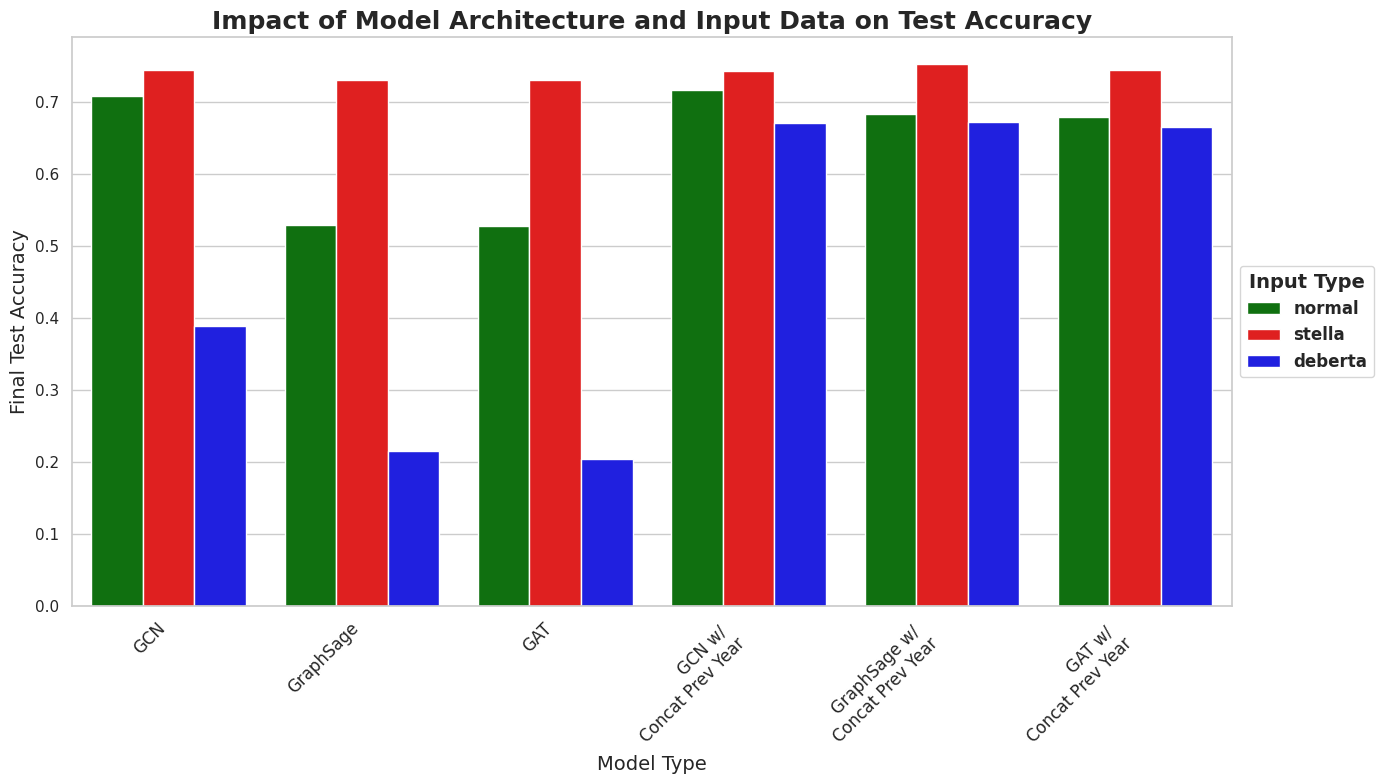

In [8]:
# Create a group column that combines model_type and concat_prev_year
def create_group_name(row):
    if row['concat_prev_year']:
        return f"{row['model_type']} w/ \n Concat Prev Year"
    else:
        return row['model_type']

best_models_df['group'] = best_models_df.apply(create_group_name, axis=1)

group_order = [
    'GCN',
    'GraphSage',
    'GAT',
    'GCN w/ \n Concat Prev Year',
    'GraphSage w/ \n Concat Prev Year',
    'GAT w/ \n Concat Prev Year'
]

input_order = ['normal', 'stella', 'deberta']
color_palette = {'normal': 'green', 'stella': 'red', 'deberta': 'blue'}

# Ensure 'input_type' is ordered categorically
best_models_df['input_type'] = pd.Categorical(best_models_df['input_type'], categories=input_order, ordered=True)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(
    data=best_models_df,
    x='group',
    y='final_test_acc',
    hue='input_type',
    order=group_order,
    hue_order=input_order,
    palette=color_palette
)

plt.title('Impact of Model Architecture and Input Data on Test Accuracy', fontsize=18, fontweight='bold')

plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Final Test Accuracy', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)

legend = plt.legend(
    title='Input Type',
    title_fontsize=14,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    frameon=True,
    fancybox=True
)

for text in legend.get_texts():
    text.set_fontweight('bold')

legend.get_title().set_fontweight('bold')
plt.tight_layout()
plt.savefig('model_arch_impact_test_acc.png', dpi=300)
plt.show()

The second plot presents the same data organized by input type, highlighting how each model configuration performs within each input category.

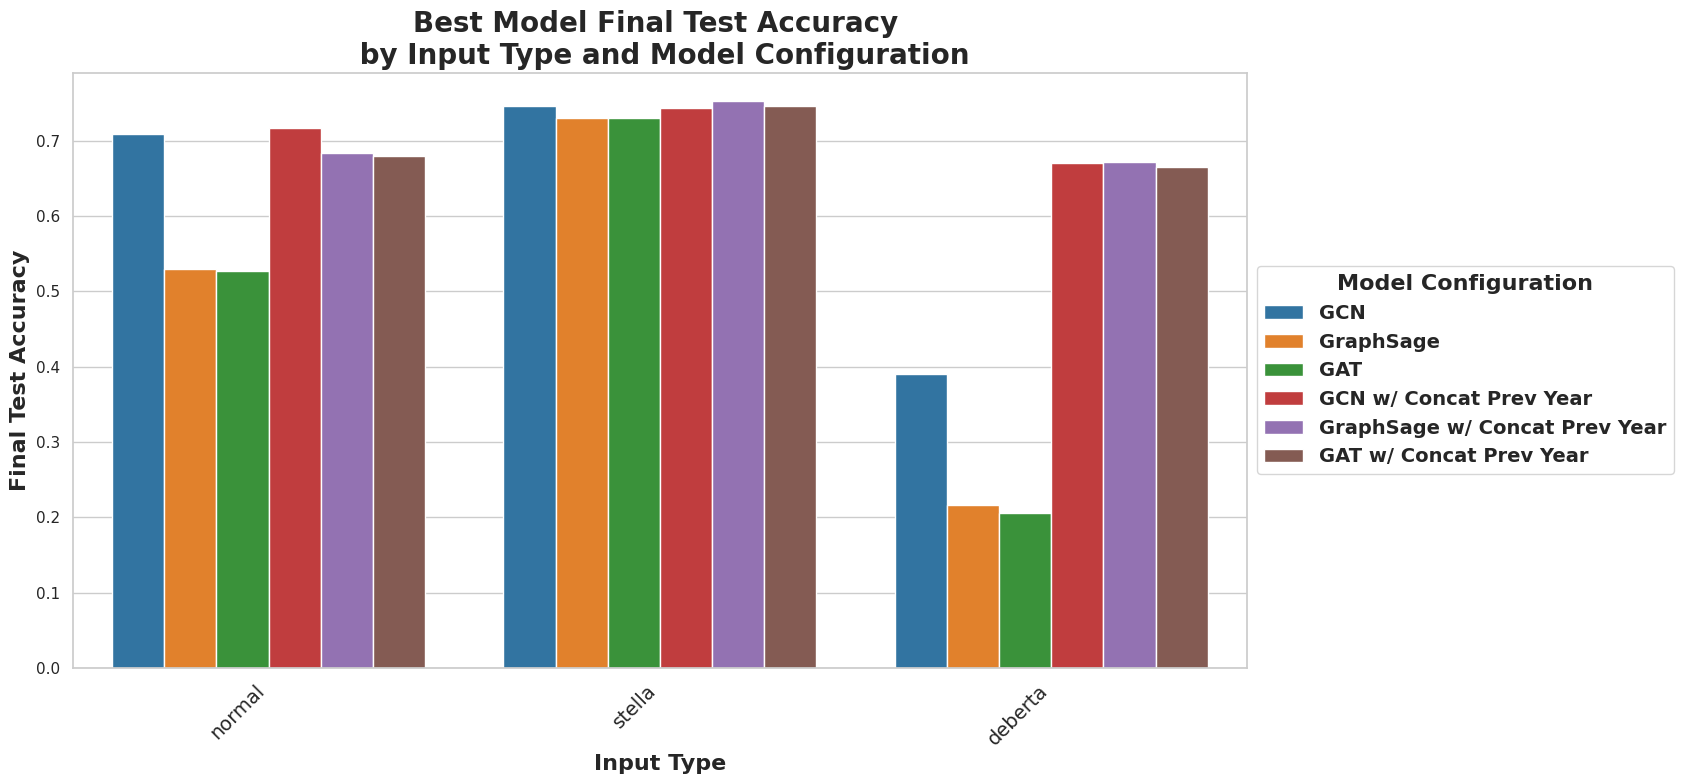

In [9]:
# make a group column that combines model_type and concat_prev_year
def create_group_name(row):
    if row['concat_prev_year']:
        return f"{row['model_type']} w/ Concat Prev Year"
    else:
        return row['model_type']

best_models_df['group'] = best_models_df.apply(create_group_name, axis=1)

group_order = ['normal', 'stella', 'deberta']

hue_order = [
    'GCN',
    'GraphSage',
    'GAT',
    'GCN w/ Concat Prev Year',
    'GraphSage w/ Concat Prev Year',
    'GAT w/ Concat Prev Year'
]

# distinct colors to each model configuration
color_palette = {
    'GCN': '#1f77b4',                      # Blue
    'GraphSage': '#ff7f0e',                # Orange
    'GAT': '#2ca02c',                      # Green
    'GCN w/ Concat Prev Year': '#d62728',  # Red
    'GraphSage w/ Concat Prev Year': '#9467bd',  # Purple
    'GAT w/ Concat Prev Year': '#8c564b'   # Brown
}

sns.set_theme(style="whitegrid")

# bar plot
plt.figure(figsize=(17, 8))
bar_plot = sns.barplot(
    data=best_models_df,
    x='input_type',
    y='final_test_acc',
    hue='group',
    order=group_order,
    hue_order=hue_order,
    palette=color_palette,
    dodge=True
)

plt.title('Best Model Final Test Accuracy \n by Input Type and Model Configuration', fontsize=20, fontweight='bold')
plt.xlabel('Input Type', fontsize=16, fontweight='bold')
plt.ylabel('Final Test Accuracy', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)

# legend
legend = plt.legend(
    title='Model Configuration',
    title_fontsize=16,
    fontsize=14,
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    frameon=True,
    fancybox=True
)

for text in legend.get_texts():
    text.set_fontweight('bold')

legend.get_title().set_fontweight('bold')
plt.tight_layout()
plt.savefig('model_config_impact_test_acc.png', dpi=300)
plt.show()

The following code here groups the data by model type and whether previous-year category labels were concatenated, and then plots a bar chart showing the maximum final test accuracy for each configuration. This visualization serves as an ablation study to compare how different model architectures perform with and without the additional category information from previously cited papers.

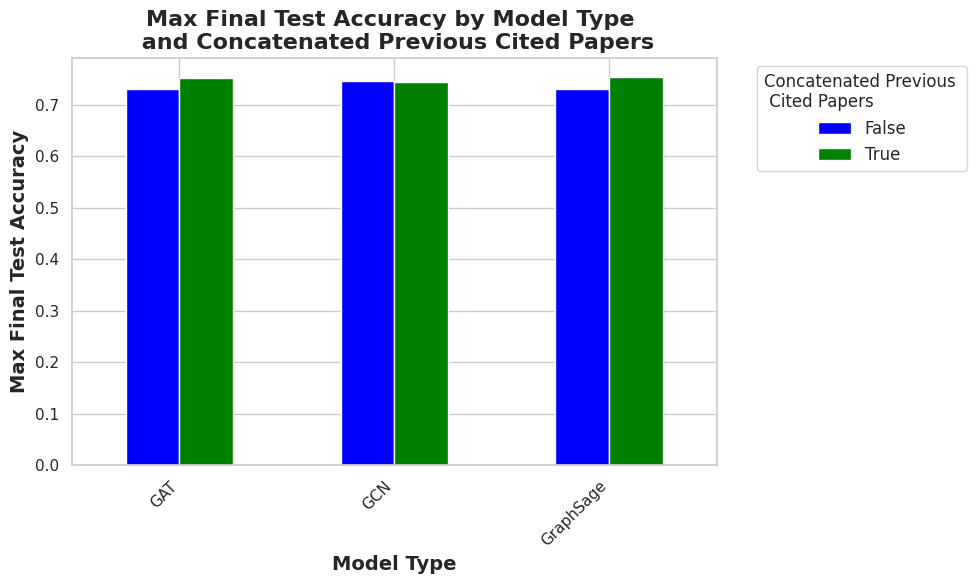

In [ ]:
# filtering for relevant data
stella_df = concatenated_results_summary_df[concatenated_results_summary_df['input_type'] == 'stella']
stella_grouped = stella_df.groupby(['model_type', 'concat_prev_year'])['final_test_acc'].max().unstack()

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10,6))

# grouped bar plot
stella_grouped.plot(kind='bar', ax=ax, color=['blue', 'green'])

plt.title('Max Final Test Accuracy by Model Type \n and Concatenated Previous Cited Papers', fontsize=16, fontweight='bold')
plt.xlabel('Model Type', fontsize=14, fontweight='bold')
plt.ylabel('Max Final Test Accuracy', fontsize=14, fontweight='bold')

# providing legend for graph
plt.legend(title='Concatenated Previous \n Cited Papers', labels=['False', 'True'],
           bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=12, fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('max_final_test_accuracy_stella.png', dpi=300)
plt.show()

Here we load in our best model from the Training Experiments.

The content of the best model is also stored in a folder called `best_model_content` inside of the [Google Drive Folder](https://drive.google.com/drive/u/4/folders/1ts4JjQM8GCAIQF-snod-3pJ10uZN1avI) to download.

Please load in the contents of that folder into a folder called `best_model_content` in the current directory and run the following code below.

| Parameter                         | Value         |
|-----------------------------------|---------------|
| **Model Type**                    | GraphSage     |
| **Input Type**                    | stella        |
| **Concatenate Previous Year**     | TRUE          |
| **Number of Layers**              | 2             |
| **Number of Heads**               | 1             |
| **Hidden Dimension**              | 512           |
| **Dropout Rate**                  | 0.5           |
| **Number of Epochs**              | 100           |
| **Optimizer**                     | adam          |
| **Learning Rate**                 | 0.01          |
| **Weight Decay Rate**             | 0.0005        |
| **Best Validation Accuracy**      | 0.7612        |
| **Best Test Accuracy**            | 0.753842      |
| **Min Training Loss During Training** | 0.837908  |


In [ ]:
os.makedirs("best_model_content", exist_ok=True)

In [11]:
best_model_curves_df = pd.read_csv("best_model_content/curves.csv")

display(best_model_curves_df)
print(best_model_curves_df)

,epoch,train_acc,val_acc,test_acc,train_loss
0,0,0.179061,0.076278,0.058618,3.688944
1,1,0.179061,0.076278,0.058618,3.302401
2,2,0.335118,0.428907,0.463799,3.164767
3,3,0.314226,0.342159,0.329404,3.013321
4,4,0.333722,0.328065,0.295023,2.870210
...,...,...,...,...,...
95,95,0.708998,0.719923,0.734317,1.006506
96,96,0.735411,0.731165,0.726169,1.059480
97,97,0.729330,0.736233,0.733864,0.968262
98,98,0.735664,0.738045,0.744110,1.020323


    epoch  train_acc   val_acc  test_acc  train_loss
0       0   0.179061  0.076278  0.058618    3.688944
1       1   0.179061  0.076278  0.058618    3.302401
2       2   0.335118  0.428907  0.463799    3.164767
3       3   0.314226  0.342159  0.329404    3.013321
4       4   0.333722  0.328065  0.295023    2.870210
..    ...        ...       ...       ...         ...
95     95   0.708998  0.719923  0.734317    1.006506
96     96   0.735411  0.731165  0.726169    1.059480
97     97   0.729330  0.736233  0.733864    0.968262
98     98   0.735664  0.738045  0.744110    1.020323
99     99   0.736390  0.739052  0.734255    0.978822

[100 rows x 5 columns]


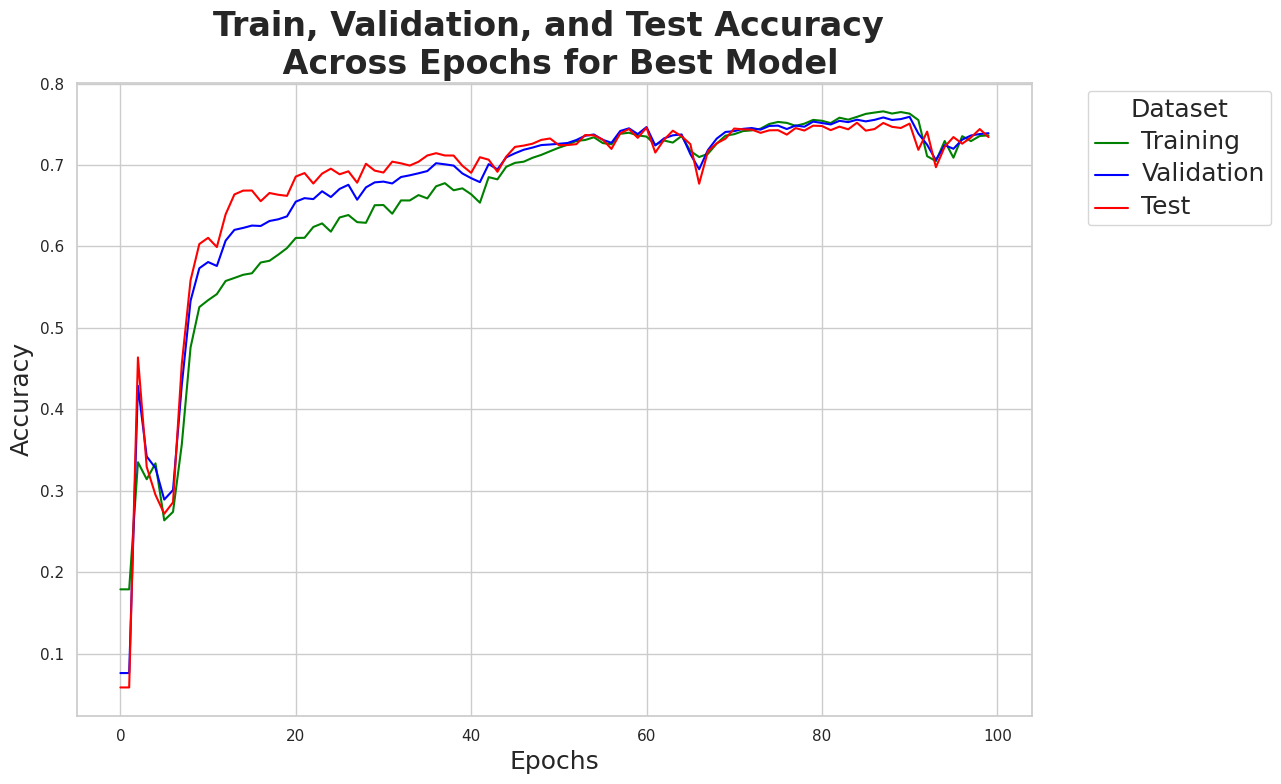

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(13,8))

# Plot the curves for each Dataset
sns.lineplot(x='epoch', y='train_acc', data=best_model_curves_df, color='green', label='Training', ax=ax)
sns.lineplot(x='epoch', y='val_acc', data=best_model_curves_df, color='blue', label='Validation', ax=ax)
sns.lineplot(x='epoch', y='test_acc', data=best_model_curves_df, color='red', label='Test', ax=ax)

plt.title("Train, Validation, and Test Accuracy \n Across Epochs for Best Model", fontsize=24, fontweight='bold')
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Accuracy", fontsize=18)

legend = ax.legend(title="Dataset", title_fontsize=18, fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.setp(legend.get_texts(), fontsize=18)
plt.tight_layout()

plt.savefig("best_model_epoch_curve.png")

plt.show()

The Other Diagrams for the analysis Section can be found in this [Github Link](https://github.com/KDharmarajanDev/cs224w-final/tree/main).

## Miscellaneous

The following code is just to help with downloading results of data from the `trained_models` folder

In [ ]:
import os
import shutil
from google.colab import files

trained_models_dir = 'trained_models'

if not os.path.exists(trained_models_dir):
    raise ValueError(f"The directory '{trained_models_dir}' does not exist.")

subfolders = [f for f in os.listdir(trained_models_dir)
             if os.path.isdir(os.path.join(trained_models_dir, f))]

if not subfolders:
    print(f"No subfolders found in '{trained_models_dir}'.")
else:
    print(f"Found {len(subfolders)} subfolders in '{trained_models_dir}':")
    for folder in subfolders:
        print(f" - {folder}")
    print("\nStarting the zipping and downloading process...\n")
    for folder in subfolders:
        try:
            folder_path = os.path.join(trained_models_dir, folder)
            zip_filename = f"{folder}.zip"
            shutil.make_archive(folder, 'zip', folder_path)
            print(f"Created ZIP file: {zip_filename}")
            files.download(zip_filename)
            print(f"Download initiated for: {zip_filename}\n")
        except Exception as e:
            print(f"An error occurred while processing '{folder}': {e}")

Found 13 subfolders in 'trained_models':
 - normal_ogbn_GCN
 - stella_ogbn_GAT_num_layers_3
 - deberta_ogbn_GCN_num_layers_3
 - deberta_ogbn_GAT_num_layers_2
 - deberta_ogbn_GraphSage
 - deberta_ogbn_GAT_num_layers_3
 - normal_ogbn_GAT_num_layers_3
 - stella_ogbn_GAT_num_layers_2
 - deberta_ogbn_GCN
 - normal_ogbn_GraphSage
 - stella_ogbn_GCN
 - normal_ogbn_GAT_num_layers_2
 - stella_ogbn_GraphSage

Starting the zipping and downloading process...

Created ZIP file: normal_ogbn_GCN.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: normal_ogbn_GCN.zip

Created ZIP file: stella_ogbn_GAT_num_layers_3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: stella_ogbn_GAT_num_layers_3.zip

Created ZIP file: deberta_ogbn_GCN_num_layers_3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: deberta_ogbn_GCN_num_layers_3.zip

Created ZIP file: deberta_ogbn_GAT_num_layers_2.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: deberta_ogbn_GAT_num_layers_2.zip

Created ZIP file: deberta_ogbn_GraphSage.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: deberta_ogbn_GraphSage.zip

Created ZIP file: deberta_ogbn_GAT_num_layers_3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: deberta_ogbn_GAT_num_layers_3.zip

Created ZIP file: normal_ogbn_GAT_num_layers_3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: normal_ogbn_GAT_num_layers_3.zip

Created ZIP file: stella_ogbn_GAT_num_layers_2.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: stella_ogbn_GAT_num_layers_2.zip

Created ZIP file: deberta_ogbn_GCN.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: deberta_ogbn_GCN.zip

Created ZIP file: normal_ogbn_GraphSage.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: normal_ogbn_GraphSage.zip

Created ZIP file: stella_ogbn_GCN.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: stella_ogbn_GCN.zip

Created ZIP file: normal_ogbn_GAT_num_layers_2.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: normal_ogbn_GAT_num_layers_2.zip

Created ZIP file: stella_ogbn_GraphSage.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: stella_ogbn_GraphSage.zip

